<a href="https://colab.research.google.com/github/maciejskorski/new_pll_trng/blob/main/TRNG_Dependency_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilities

Run to install required software and prepare auxiliary functions. 

In [12]:
# update Python lib - and restart the kernel when necessary
!pip install --upgrade statsmodels --quiet
!pip install --upgrade seaborn --quiet
!pip install mlflow --quiet
!pip install pyngrok --quiet
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 1s (81.9 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 122349 files and directories currently install

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pandas as pd
import numpy as np
import tempfile
import io
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from pathlib import Path
import re
import itertools

from IPython.display import display

import multiprocessing as mp

import logging
import mlflow
from pyngrok import ngrok
from getpass import getpass

plt.rcParams['figure.figsize'] = (10,3)
logger = logging.getLogger('TRNG Analysis')
logger.setLevel(logging.INFO)


def read_dff(filename, KM, KD):
  """ Read dff bits from the raw file. Return a matrix of shape (n_cycles, KD)  """
  bytes_data = np.fromfile(filename, dtype="uint8") # read bytes
  bits_data = np.unpackbits(bytes_data, axis=None, count=None, bitorder='little') # unpack to bits
  bits_data = bits_data.reshape((-1,32))[:,::-1].ravel() # reverse bits order in blocks of 32
  bits_data = np.resize(bits_data,(len(bits_data)//KD,KD)) # reshape to cycles
  return bits_data


def get_bytes_data(fpath):
  with open(fpath,'rb') as f:
    bytes_data = f.read()
  bytes_data = pd.DataFrame(list(bytes_data),columns=['byte value'])
  bytes_data.index.name = 'timestep'
  return bytes_data


def get_metadata(fpath):
  """ Read mean and alan variance, as stored in log* files """
  with open(fpath,'r') as f:
    metadata = f.read()
    rgx_mean = re.compile('\nMean:\s+(\d+.\d+)')
    rgx_alan = re.compile('\nAllan variance:\s+(\d+.\d+)')
    mean = float(rgx_mean.search(metadata).group(1))
    var_alan = float(rgx_alan.search(metadata).group(1))
    return mean,var_alan


def counter_val(x):
  return x


def last_bit(x):
  return x % 2


def diff_last_bit(x):
  return x.diff().loc[1:] % 2


def analyze_series(bytes_data, nlags=10, alpha=0.05, postprocess_fn=last_bit):
  """ Analyze dependencies of TRNG bytes candidate.
      Args:
          bytes_data (pandas.DataFrame): series of raw bytes (das), encoded as integers uint8
          nlags (int): maximum number of lags to analyse
          alpha (float): confidence level for hypothesis testing
          postprocess_fn (function): transform applied to the series. For example, use <mod 2> to extract the last significant bit
      Return:
          figure: picture with plots
  """
  params = {
        'lags':nlags,
        'alpha':alpha,
        'postprocess_fn':postprocess_fn.__name__
  }
  mlflow.log_params(params)
  fig,axs = plt.subplots(1,2,constrained_layout=True)
  # plot histogram
  ax = axs[0]
  sns.histplot(data=bytes_data,x='byte value',ax=ax,discrete=True)
  # plot time series
  ax = axs[1]
  sns.lineplot(data=bytes_data.loc[:1000],x='timestep',y='byte value',ax=ax)
  plt.show()
  mlflow.log_figure(fig,'exploratory.png')
  bytes_data = postprocess_fn(bytes_data)
  # descriptive stats
  if postprocess_fn==counter_val:
    mlflow.log_metric('mean',bytes_data.mean())
  # stationarity tests on postprocessed data
  results = kpss(bytes_data,nlags=10)
  pval = results[1]
  mlflow.log_metric(f'stationary.KPSS.lag_{nlags}',pval)
  results = adfuller(bytes_data,maxlag=10)
  pval = results[1]
  mlflow.log_metric(f'not-stationary.ADF.lag_{nlags}',pval)
  # plot autocorelation by 
  fig,ax = plt.subplots(1,1,constrained_layout=True)
  fig = plot_acf(x=bytes_data, lags = nlags, fft=True, alpha=alpha, bartlett_confint=True, zero=False, adjusted=True, ax=ax, auto_ylims=True)
  ax.set(xlabel='Lag',ylabel='Corr')
  plt.show()
  mlflow.log_figure(fig,'autocorrelation.png')
  # find p-values for autocorrelation
  _,_,_,pvals = acf(
          x=bytes_data,
          nlags=nlags,
          alpha=alpha,
          fft=True,
          bartlett_confint=True,
          adjusted=True,
          qstat=True
  )
  pvals = {'lag':np.arange(1,nlags+1),'Ljung-Box Test p-val':pvals}
  pvals = pd.DataFrame(data=pvals)
  pvals.set_index('lag',inplace=True)
  display(pvals)
  mlflow.log_metric(f'not-correlated.LjungBox.lag_{nlags}',pvals.loc[nlags])

# Logging

Result outcomes are tracked with `mlflow`, and interactively presented under the temporary domain set up with `ngrok`.

In [3]:
# Run mlflow server
get_ipython().system_raw("mlflow ui --port 5000 &")

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')  
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPS tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)

mlflow.set_tracking_uri(ngrok_tunnel.public_url)
logger.info(f"MLflow Tracking UI:{ngrok_tunnel.public_url}")

Enter the ngrok authtoken: ··········


INFO:TRNG Analysis:MLflow Tracking UI:https://f5cc-34-133-13-111.ngrok-free.app


# Data

Download data from various cards to run the analysis scripts and stasticial tests.

NOTE: the data should be put under the default root folder `/content` of Google Colab, either by clonning the git repo or uploading manually.

In [9]:
GITHUB_TOKEN = getpass('Enter the GitHub token to clone the repo: ')
!git clone https://{GITHUB_TOKEN}@github.com/maciejskorski/new_pll_trng.git
!ls new_pll_trng/data

Enter the GitHub token to clone the repo: ··········
Cloning into 'new_pll_trng'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 201 (delta 13), reused 51 (delta 10), pack-reused 144
Receiving objects: 100% (201/201), 150.63 MiB | 19.41 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Updating files: 100% (47/47), done.
CVv12_4  data.zip  S6v11_2  S6v11_8  SF2v11_11


In [16]:
!tree -d new_pll_trng/data

new_pll_trng/data
├── CVv12_4
│   ├── A_1
│   ├── A_2
│   ├── B_1
│   ├── B_2
│   ├── C_1
│   └── C_2
├── S6v11_2
│   ├── A_1
│   ├── A_2
│   ├── B_1
│   ├── B_2
│   ├── C_1
│   └── C_2
├── S6v11_8
│   ├── a1
│   ├── a2
│   ├── b1
│   ├── b2
│   ├── c1
│   └── c2
└── SF2v11_11
    ├── A_1
    ├── A_2
    ├── B_1
    ├── B_2
    ├── C_1
    └── C_2

28 directories


### Cyclone

In [ ]:
!curl -L "https://filesender.renater.fr/download.php?token=a6a8e94b-d88f-4fae-8800-7d727344c5ec&files_ids=20824359" --output Viktor_0110.zip
!unzip -q Viktor_0110.zip -d CycloneV/
!curl -L "https://filesender.renater.fr/download.php?token=bff3eec2-4aea-4008-b442-8f6e99a80658&files_ids=20833133" --output Viktor_0110.zip
!unzip -q Viktor_0110.zip -d CycloneV/

!mv CycloneV/CV_M1_C1_regional CycloneV/Card_M1
!mv CycloneV/CV_M1_C2_regional CycloneV/Card_M1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 15660    0 15660    0     0  19004      0 --:--:-- --:--:-- --:--:-- 19004
[Viktor_0110.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of Viktor_0110.zip or
        Viktor_0110.zip.zip, and cannot find Viktor_0110.zip.ZIP, period.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 15660    0 15660    0     0  

### Spartan

In [ ]:
#!curl -L "https://filesender.renater.fr/download.php?token=091729e6-2288-4c3b-ae1c-20b0be95e4b0&files_ids=20848008" --output Spartan_0110.zip
#!unzip -q Spartan_0110.zip -d Spartan_0110/
!curl -L "https://filesender.renater.fr/download.php?token=44319ade-b602-4835-8ef4-1429712e2904&files_ids=20909857" --output Spartan6.zip
!unzip -q Spartan6.zip -d Spartan6/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52.0M  100 52.0M    0     0   600k      0  0:01:28  0:01:28 --:--:--  616k


### SmartFusiom

In [ ]:
!curl -L "https://filesender.renater.fr/download.php?token=f559b0f5-72e6-407a-8dc4-0a2410c59505&files_ids=20930627" --output SmartFusion.zip
!unzip -q SmartFusion.zip -d SmartFusion/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 54.6M  100 54.6M    0     0   604k      0  0:01:32  0:01:32 --:--:--  620k


### Special

In [ ]:
!curl -L "https://filesender.renater.fr/download.php?token=e580d76a-42ce-43ac-83fb-936ba2547b7b&files_ids=20891209" --output CV_special.zip
!unzip -q CV_special.zip -d CV_special/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7956k  100 7956k    0     0   567k      0  0:00:14  0:00:14 --:--:--  611k


# Analysis

## Configurations

Parse through all data files to extract each configuration's parameters.

In [ ]:
from collections import namedtuple

ExpConfig = namedtuple('ExpConfig','name inputfile KM KD config pll card constraint params')

def generate_configs_cyclonev(root_path='/content/CycloneV'):
  for fname in Path(root_path).glob('*/*/*.bin'):
    if 'bit.bin' not in fname.name:
      cfg_name = fname.parent.name
      km_kd_pattern = re.compile('km(\d+)_kd(\d+)')
      KM,KD = map(int,km_kd_pattern.search(str(fname)).groups())
      card_pattern = re.compile('Card_(\w+)')
      card =  card_pattern.search(str(fname)).groups()[0]
      pll_pattern = re.compile('\w(\d)_regional')
      pll = int(pll_pattern.search(str(fname)).groups()[0])
      config_pattern = re.compile('_(\w)\d_regional')
      config = 'CV_'+config_pattern.search(str(fname)).groups()[0]
      yield ExpConfig(name=cfg_name,inputfile=fname,
                      KM=KM,
                      KD=KD,
                      config=config,
                      pll=pll,
                      card=card,
                      constraint=None,
                      params = {'bit_pdf':True,'bits_intra_correlation':True}
                    )


def generate_configs_spartan(root_path='/content/Spartan6/'):
  for fname in Path(root_path).glob('*/*/*/*.bin'):
    if 'bit.bin' not in fname.name:
      cfg_name = fname.parent.name
      km_kd_pattern = re.compile('km(\d+)_kd(\d+)')
      KM,KD = map(int,km_kd_pattern.search(str(fname)).groups())
      card_pattern = re.compile('card_(\w+)')
      card = int(card_pattern.search(str(fname)).groups()[0])
      pll_pattern = re.compile('\w_(\d)/acq')
      pll = int(pll_pattern.search(str(fname)).groups()[0])
      config_pattern = re.compile('(\w+)_\d/acq')
      config = 'S6_'+config_pattern.search(str(fname)).groups()[0].upper()
      yield ExpConfig(name=cfg_name,inputfile=fname,
                      KM=KM,
                      KD=KD,
                      pll=pll,
                      card=card,
                      config=config, 
                      constraint=None,
                      params = {'bit_pdf':True,'bits_intra_correlation':True}
                    )
      
def generate_configs_smartfusion(root_path='/content/SmartFusion/'):
  for fname in Path(root_path).glob('*/*/*/*.bin'):
    if 'bit.bin' not in fname.name:
      cfg_name = fname.parent.name
      km_kd_pattern = re.compile('km(\d+)_kd(\d+)')
      KM,KD = map(int,km_kd_pattern.search(str(fname)).groups())
      card_pattern = re.compile('card_(\w+)')
      card = int(card_pattern.search(str(fname)).groups()[0])
      pll_pattern = re.compile('\w(\d)/acq')
      pll = int(pll_pattern.search(str(fname)).groups()[0])
      config_pattern = re.compile('(\w+)\d/acq')
      config = 'SF_'+config_pattern.search(str(fname)).groups()[0].upper()
      yield ExpConfig(name=cfg_name,inputfile=fname,
                      KM=KM,
                      KD=KD,
                      pll=pll,
                      card=card,
                      config=config, 
                      constraint=None,
                      params = {'bit_pdf':True,'bits_intra_correlation':True}
                    )

def generate_configs_special(root_path='/CV_special'):
  for fname in Path(root_path).glob('*/*/*.bin'):
    if 'bit.bin' not in fname.name:
      cfg_name = fname.parent.name
      km_kd_pattern = re.compile('km(\d+)_kd(\d+)')
      KM,KD = map(int,km_kd_pattern.search(str(fname)).groups())
      card_pattern = re.compile('Card_M(\d)')
      card = int(card_pattern.search(str(fname)).groups()[0])
      pll_pattern = re.compile('\w_(\d)/acq')
      pll = int(pll_pattern.search(str(fname)).groups()[0])
      config_pattern = re.compile('(\w+)_\d/acq')
      config = '_'.join(config_pattern.search(str(fname)).groups())
      yield ExpConfig(name=cfg_name,inputfile=fname,
                      KM=KM,
                      KD=KD,
                      pll=pll,
                      card=card,
                      config=config,
                      constraint=None, 
                      params = {'bit_pdf':True,'bits_intra_correlation':True}
                    )

cfgs = list( generate_configs_smartfusion() )
assert(len(cfgs)==12)
print(cfgs)

[ExpConfig(name='b1', inputfile=PosixPath('/content/SmartFusion/SmartFusion2/card_11/b1/acq_20230113113656_km368_kd279_dff.bin'), KM=368, KD=279, config='SF_B', pll=1, card=11, params={'bit_pdf': True, 'bits_intra_correlation': True}), ExpConfig(name='c2', inputfile=PosixPath('/content/SmartFusion/SmartFusion2/card_11/c2/acq_20230106125902_km304_kd225_dff.bin'), KM=304, KD=225, config='SF_C', pll=2, card=11, params={'bit_pdf': True, 'bits_intra_correlation': True}), ExpConfig(name='c1', inputfile=PosixPath('/content/SmartFusion/SmartFusion2/card_11/c1/acq_20230106125650_km304_kd225_dff.bin'), KM=304, KD=225, config='SF_C', pll=1, card=11, params={'bit_pdf': True, 'bits_intra_correlation': True}), ExpConfig(name='a1', inputfile=PosixPath('/content/SmartFusion/SmartFusion2/card_11/a1/acq_20230106124038_km728_kd435_dff.bin'), KM=728, KD=435, config='SF_A', pll=1, card=11, params={'bit_pdf': True, 'bits_intra_correlation': True}), ExpConfig(name='a2', inputfile=PosixPath('/content/SmartFus

## Stationarity

Run the KPSS statistical test against all configurations, to check for counter stationarity, as well as DFF stationarity. 

In [ ]:
all_configs = itertools.chain(generate_configs_cyclonev(),generate_configs_spartan(),generate_configs_smartfusion())

In [ ]:
def counter_val(x):
  return x

def last_bit(x):
  return x%2

experiment_name = "Stationarity tests for output bits"
try:
  experiment_id = mlflow.create_experiment(experiment_name)
except:
  pass

def get_stationarity(cfg, alpha=0.05):
  for postprocess_fn in [counter_val,last_bit]:
    with mlflow.start_run(experiment_id=experiment_id):
      mlflow.log_param('file',cfg.inputfile)
      mlflow.log_param('KM',cfg.KM)
      mlflow.log_param('KD',cfg.KD)
      mlflow.log_param('config',cfg.config)
      mlflow.log_param('pll',cfg.pll)
      mlflow.log_param('card',cfg.card)
      mlflow.log_param('postprocessing',postprocess_fn.__name__)
      KM = cfg.KM
      KD = cfg.KD
      bits = read_dff(cfg.inputfile,KM=KM,KD=KD)
      bits = bits.astype('int32')
      counter = bits.sum(1)
      results = kpss(postprocess_fn(counter))
      pval = results[1]
      mlflow.log_metric('KPSS',pval)
      results = adfuller(postprocess_fn(counter),maxlag=10)
      pval = results[1]
      mlflow.log_metric('ADF',pval)

with mp.Pool(4) as p:
  p.map(get_stationarity,all_configs)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-va

In [ ]:
keep_cols = ['metrics.KPSS','metrics.ADF','params.config','params.card','params.postprocessing','params.pll']
filter_string = "params.pll='1'"
out = mlflow.search_runs(experiment_id,filter_string=filter_string)[keep_cols]
out.columns = map(lambda s: s.replace('metrics.','').replace('params.',''),out.columns)
postprocess_dict = {'counter_val':'counter','last_bit':'raw bit'}
out['postprocessing'] = out['postprocessing'].apply(postprocess_dict.get)
card_dict = {'M1':1,'M2':2,'7':1,'8':2,'10':1,'11':2}
out['card'] = out['config']+out['card'].apply(card_dict.get).astype(str)
out = pd.melt(out, id_vars=['config','card','postprocessing','pll'], value_vars=['KPSS', 'ADF'], var_name='test', value_name='p-value')
out = out.pivot(index=['config','card','pll'],columns=['postprocessing','test',]).sort_index(axis=1)
out.columns.names = ['','','test']
key = out.index.get_level_values('config').to_series()
key = key.str.slice(-1,)+key.str.slice(0,-1)
out = out.set_index(key,append=True,).sort_index(level=-1).droplevel(-1)

out

p-value                            
                 counter           raw bit          
test                 ADF      KPSS     ADF      KPSS
config card  pll                                    
CV_A   CV_A1 1       0.0  0.010000     0.0  0.100000
       CV_A2 1       0.0  0.010000     0.0  0.100000
S6_A   S6_A1 1       0.0  0.010000     0.0  0.100000
       S6_A2 1       0.0  0.023301     0.0  0.100000
SF_A   SF_A1 1       0.0  0.010000     0.0  0.100000
       SF_A2 1       0.0  0.100000     0.0  0.017617
CV_B   CV_B1 1       0.0  0.010000     0.0  0.100000
       CV_B2 1       0.0  0.010000     0.0  0.088898
S6_B   S6_B1 1       0.0  0.010000     0.0  0.100000
       S6_B2 1       0.0  0.098015     0.0  0.100000
SF_B   SF_B1 1       0.0  0.010000     0.0  0.010327
       SF_B2 1       0.0  0.010000     0.0  0.100000
CV_C   CV_C1 1       0.0  0.010000     0.0  0.096214
       CV_C2 1       0.0  0.010000     0.0  0.100000
S6_C   S6_C1 1       0.0  0.010000     0.0  0.013689
       S6_C2 1       0.0  0.100000     0.0  0.100000
SF_C   SF_C1 1       0.0  0.068183     0.0  0.100000
       SF_C2 1       0.0  0.010000     0.0  0.100000

In [ ]:
keep_cols = ['metrics.KPSS','metrics.ADF','params.config','params.card','params.postprocessing',]
filter_string = "params.pll='1'"
out = mlflow.search_runs(experiment_id,filter_string=filter_string)[keep_cols]
out.columns = map(lambda s: s.replace('metrics.','').replace('params.',''),out.columns)
postprocess_dict = {'counter_val':'counter','last_bit':'raw bit'}
out['postprocessing'] = out['postprocessing'].apply(postprocess_dict.get)
card_dict = {'M1':1,'M2':2,'7':1,'8':2,'10':1,'11':2}
out['card'] = out['config'].str.slice(0,2)+out['card'].apply(card_dict.get).astype(str)
out = pd.melt(out, id_vars=['config','card','postprocessing',], value_vars=['KPSS', 'ADF'], var_name='test', value_name='p-value')
out = out.pivot(index=['config','card',],columns=['postprocessing','test',]).sort_index(axis=1)
out.columns.names = ['','','test']
key = out.index.get_level_values('config').to_series()
key = key.str.slice(-1,)+key.str.slice(0,-1)
out = out.set_index(key,append=True,).sort_index(level=-1).droplevel(-1)

style_TRNG_OK = 'color:Green; font-weight: bold'
out = out\
  .style\
  .format(precision=2,escape="latex")\
  .applymap(lambda x: style_TRNG_OK if x>=0.05 else '', subset=[('p-value','counter','KPSS',)])\
  .applymap(lambda x: style_TRNG_OK if x>=0.05 else '', subset=[('p-value','raw bit', 'KPSS',)])\
  .applymap(lambda x: style_TRNG_OK if x<0.05 else '', subset=[('p-value','counter','ADF',)])\
  .applymap(lambda x: style_TRNG_OK if x<0.05 else '', subset=[('p-value','raw bit', 'ADF',)])

display(out)

latex_code = out\
  .to_latex(
      hrules=True,
      convert_css=True,
      position_float = 'centering',
      caption='Results of stationarity tests (p-values for KPSS and ADF tests).',
      label='tab:output_stationarity',
    )

latex_code = latex_code.replace('_A','\_A')
latex_code = latex_code.replace('_B','\_B')
latex_code = latex_code.replace('_C','\_C')
latex_code

'\\begin{table}\n\\centering\n\\caption{Results of stationarity tests (p-values for KPSS and ADF tests).}\n\\label{tab:output_stationarity}\n\\begin{tabular}{llrrrr}\n\\toprule\n{} & {} & \\multicolumn{4}{r}{p-value} \\\\\n{} & {} & \\multicolumn{2}{r}{counter} & \\multicolumn{2}{r}{raw bit} \\\\\n{} & {test} & {ADF} & {KPSS} & {ADF} & {KPSS} \\\\\n{config} & {card} & {} & {} & {} & {} \\\\\n\\midrule\n\\multirow[c]{2}{*}{CV\\_A} & CV1 & \\color{Green} \\bfseries 0.00 & 0.01 & \\color{Green} \\bfseries 0.00 & \\color{Green} \\bfseries 0.10 \\\\\n & CV2 & \\color{Green} \\bfseries 0.00 & 0.01 & \\color{Green} \\bfseries 0.00 & \\color{Green} \\bfseries 0.10 \\\\\n\\multirow[c]{2}{*}{S6\\_A} & S61 & \\color{Green} \\bfseries 0.00 & 0.01 & \\color{Green} \\bfseries 0.00 & \\color{Green} \\bfseries 0.10 \\\\\n & S62 & \\color{Green} \\bfseries 0.00 & 0.02 & \\color{Green} \\bfseries 0.00 & \\color{Green} \\bfseries 0.10 \\\\\n\\multirow[c]{2}{*}{SF\\_A} & SF1 & \\color{Green} \\bfseries 0.

## Serial Correlation

Run the Ljung-Box statistical test against all configurations, to check for correlations between counter values, as well as dff outputs.

In [ ]:
all_configs = itertools.chain(generate_configs_cyclonev(),generate_configs_spartan(),generate_configs_smartfusion())

experiment_name = "Serial correlation tests for output bits"
try:
  experiment_id = mlflow.create_experiment(experiment_name)
except:
  pass

def get_correlation(cfg,alpha=0.05):
  for postprocess_fn in [counter_val,last_bit]:
    with mlflow.start_run(experiment_id=experiment_id):
      mlflow.log_param('file',cfg.inputfile)
      mlflow.log_param('KM',cfg.KM)
      mlflow.log_param('KD',cfg.KD)
      mlflow.log_param('config',cfg.config)
      mlflow.log_param('pll',cfg.pll)
      mlflow.log_param('card',cfg.card)
      mlflow.log_param('postprocessing',postprocess_fn.__name__)
      mlflow.log_param('confidence',alpha)
      KM = cfg.KM
      KD = cfg.KD
      bits = read_dff(cfg.inputfile,KM=KM,KD=KD)
      bits = bits.astype('int32')
      counter = bits.sum(1)
      _,_,_,pvals=acf(postprocess_fn(counter),qstat=True,alpha=alpha)
      pval = pvals[-1] # TODO: double-check this
      mlflow.log_metric('LjungBox',pval)


with mp.Pool(4) as p:
  p.map(get_correlation,all_configs)

In [ ]:
keep_cols = ['metrics.LjungBox','params.config','params.card','params.postprocessing']
filter_string = 'params.pll="1"'
out = mlflow.search_runs(experiment_id,filter_string=filter_string)[keep_cols]
out.columns = map(lambda s: s.replace('metrics.','').replace('params.',''),out.columns)
card_dict = {'M1':1,'M2':2,'7':1,'8':2,'10':1,'11':2}
out['card'] = out['config'].str.slice(0,2)+out['card'].apply(card_dict.get).astype(str)
postprocess_dict = {'counter_val':'counter','last_bit':'raw bit'}
out['postprocessing'] = out['postprocessing'].apply(postprocess_dict.get)
out = out.pivot(index=['config','card'],columns='postprocessing')
out.columns.names = ['','']
key = out.index.get_level_values('config').to_series()
key = key.str.slice(-1,)+key.str.slice(0,-1)
out = out.set_index(key,append=True,).sort_index(level=-1).droplevel(-1)

style_TRNG_OK = 'color:Green; font-weight: bold'
out = out\
  .style\
  .format(precision=2,escape="latex")\
  .applymap(lambda x: style_TRNG_OK if x>=0.05 else '', subset=[('LjungBox','counter')])\
  .applymap(lambda x: style_TRNG_OK if x>=0.05 else '', subset=[('LjungBox','raw bit')])

display(out)

latex_code = out\
  .to_latex(
      hrules=True,
      convert_css=True,
      position_float = 'centering',
      caption='Results of serial correlation tests',
      label='tab:serial_correlation',
    )

latex_code = latex_code.replace('_A','\_A')
latex_code = latex_code.replace('_B','\_B')
latex_code = latex_code.replace('_C','\_C')
latex_code

'\\begin{table}\n\\centering\n\\caption{Results of serial correlation tests}\n\\label{tab:serial_correlation}\n\\begin{tabular}{llrr}\n\\toprule\n{} & {} & \\multicolumn{2}{r}{LjungBox} \\\\\n{} & {} & {counter} & {raw bit} \\\\\n{config} & {card} & {} & {} \\\\\n\\midrule\n\\multirow[c]{2}{*}{CV\\_A} & CV1 & 0.00 & \\color{Green} \\bfseries 0.29 \\\\\n & CV2 & 0.00 & \\color{Green} \\bfseries 0.05 \\\\\n\\multirow[c]{2}{*}{S6\\_A} & S61 & \\color{Green} \\bfseries 0.77 & \\color{Green} \\bfseries 0.67 \\\\\n & S62 & \\color{Green} \\bfseries 0.23 & \\color{Green} \\bfseries 0.87 \\\\\n\\multirow[c]{2}{*}{SF\\_A} & SF1 & 0.00 & \\color{Green} \\bfseries 0.06 \\\\\n & SF2 & 0.00 & \\color{Green} \\bfseries 0.55 \\\\\n\\multirow[c]{2}{*}{CV\\_B} & CV1 & 0.00 & \\color{Green} \\bfseries 0.56 \\\\\n & CV2 & 0.00 & \\color{Green} \\bfseries 0.19 \\\\\n\\multirow[c]{2}{*}{S6\\_B} & S61 & 0.00 & \\color{Green} \\bfseries 0.36 \\\\\n & S62 & \\color{Green} \\bfseries 0.46 & \\color{Green} \\bf

## Local Stationarity

We observe stochastic drifts?

LeveneResult(statistic=5.362137437733155, pvalue=0.02057875606678042)
BartlettResult(statistic=8.777747752234111, pvalue=0.0030492746854310806)


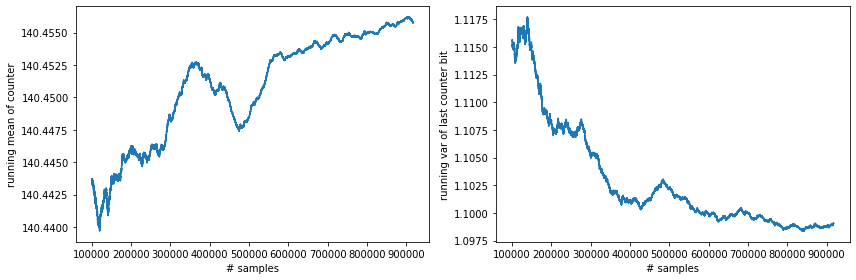

In [ ]:
from scipy.stats import bartlett
from scipy.stats import levene
from matplotlib import pyplot as plt, ticker as mticker

fname = "/content/CycloneV/Card_M1/CV_M1_B1_regional/acq_20230107141129_dff_km468_kd475.bin"
fname = "/content/SmartFusion/SmartFusion2/card_10/b1/acq_20230113112616_km368_kd279_dff.bin"
#fname = "/content/Spartan6/Spartan6/card_7/b_1/acq_20230109155612_km464_kd475_dff.bin"
KM = 368
KD = 279
bits = read_dff(fname,KM=KM,KD=KD)
bits = bits.astype('int32')
counter = bits.sum(1)

fig,axs = plt.subplots(1,2,figsize=(12,4))

x = counter
running_var = np.cumsum( (x-x.mean())**2 )/(1+np.arange(len(x)))
running_mean = np.cumsum( x )/(1+np.arange(len(x)))
ax = axs[0]
sns.lineplot(x=np.arange(len(x))[100000:],y=running_mean[100000:],ax=ax)
ax.set_xlabel('# samples')
ax.set_ylabel('running mean of counter')
ax.ticklabel_format(useOffset=False)

print(levene(x[:200000],x[200000:]))
print(bartlett(x[:200000],x[200000:]))

x = counter
running_var = np.cumsum( (x-x.mean())**2 )/(1+np.arange(len(x)))
running_mean = np.cumsum( x )/(1+np.arange(len(x)))
ax = axs[1]
sns.lineplot(x=np.arange(len(x))[100000:],y=running_var[100000:],ax=ax)
ax.set_xlabel('# samples')
ax.set_ylabel('running var of last counter bit')

plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.tight_layout()
plt.show()

In [ ]:
bits

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1]], dtype=int32)

In [ ]:
experiment_name = "Local stationarity tests for sampled bits"
try:
  experiment_id = mlflow.create_experiment(experiment_name)
except:
  pass

def kpss_multivariate(x,n_lag=200):
  resids = x-x.mean(0)
  S = resids.T.dot(resids) / len(resids)
  autocov = [resids[lag:,].T.dot(resids[:len(resids)-lag,]) for lag in range(0,n_lag+1)]
  ws = 2*np.arange(len(autocov))/len(autocov)
  ws[0] = 1
  S = (ws.reshape(-1,1,1)*autocov).sum(0) / len(resids)
  resids_cum = resids.cumsum(axis=0)
  C = np.tensordot(resids_cum,resids_cum,axes=[(0,),(0,)]) / len(resids)**2
  zeta = np.trace(C*np.linalg.inv(S))
  return zeta

def kpss_multivariate_local(x,n_lag=200,n_window=10000):
  x_block=np.resize(x,(x.shape[0]//n_window,n_window,x.shape[1]))
  statistics = list(map(kpss_multivariate,x_block))
  statistics = np.array(statistics)
  return statistics

def get_local_stationarity(cfg, alpha=0.05,n_window=10000,experiment_id=experiment_id):
  with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_param('file',cfg.inputfile)
    mlflow.log_param('KM',cfg.KM)
    mlflow.log_param('KD',cfg.KD)
    mlflow.log_param('config',cfg.config)
    mlflow.log_param('pll',cfg.pll)
    mlflow.log_param('card',cfg.card)
    KM = cfg.KM
    KD = cfg.KD
    bits = read_dff(cfg.inputfile,KM=KM,KD=KD)
    bits = bits.astype('int32')
    ps = bits.mean(0)
    good_idxs = np.arange(len(ps))[(ps >= 0.05) & (ps <= 0.95)]
    contrib_bits = bits[:,good_idxs]
    mlflow.log_metric('n_contribs',contrib_bits.shape[1])
    mlflow.log_metric('n_periods',contrib_bits.shape[0])
    stats = kpss_multivariate_local(contrib_bits,n_window=n_window)
    stat = np.median(stats)
    mlflow.log_metric('test val',stat)
    fig,ax = plt.subplots()
    sns.scatterplot(x=np.arange(len(stats)),y=stats,ax=ax)
    ax.set_title(f'KPSS test for sampled bits over blocks of {n_window} periods.' )
    ax.set_xlabel('block')
    ax.set_ylabel('test statistic')
    mlflow.log_figure(fig,'local_stationarity.svg')


all_configs = itertools.chain(
    generate_configs_cyclonev(),
    generate_configs_spartan(),
    generate_configs_smartfusion(),
)
all_configs = filter(lambda cfg:cfg.pll==1,all_configs)

with mp.Pool(4) as p:
  p.map(get_local_stationarity,all_configs)

In [ ]:
fname = "/content/CycloneV/Card_M1/CV_M1_B1_regional/acq_20230107141129_dff_km468_kd475.bin"
fname = "/content/SmartFusion/SmartFusion2/card_10/b1/acq_20230113112616_km368_kd279_dff.bin"
fname = "/content/Spartan6/Spartan6/card_8/b_1/acq_20230111155416_km464_kd475_dff.bin"
fname = "/content/Spartan6/Spartan6/card_7/b_1/acq_20230109155612_km464_kd475_dff.bin"
KM = 464
KD = 475
bits = read_dff(fname,KM=KM,KD=KD)
bits = bits.astype('int32')

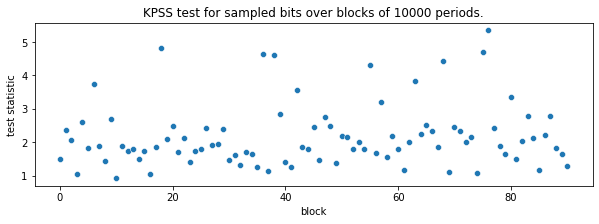

In [ ]:
n_window = 10000
ps = bits.mean(0)
good_idxs = np.arange(len(ps))[(ps >= 0.05) & (ps <= 0.95)]
contrib_bits = bits[:,good_idxs]
stats = kpss_multivariate_local(contrib_bits,n_window=n_window)
fig,ax = plt.subplots()
sns.scatterplot(x=np.arange(len(stats)),y=stats,ax=ax)
ax.set_title(f'KPSS test for sampled bits over blocks of {n_window} periods.' )
ax.set_xlabel('block')
ax.set_ylabel('test statistic')
plt.show()

In [ ]:
extreme_values = {
  1:0.727,
  2:1.078,
  3:1.370,
  4:1.626,
  5:1.874,
  10:3.022,
  20:5.186,
  30:7.187,
  40:9.179,
  50:11.018
}
extreme_values = pd.DataFrame(extreme_values.items(),columns=['dim','val'])
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(extreme_values['dim'], extreme_values['val'])

In [ ]:
keep_cols = ['params.config','params.card','metrics.n_periods','metrics.n_contribs','metrics.test val']
data = mlflow.search_runs(experiment_id)[keep_cols]
data.columns = map(lambda s: s.replace('metrics.','').replace('params.',''),data.columns)
data['critical val'] = data['n_contribs'].apply(spl)
data['pval']=data['critical val']<=data['test val']
data['pval'] = data['pval'].apply(lambda t: 0.01 if t==True else 0.1)
data.to_csv(f'{experiment_name}.csv')
data.set_index(['config','card'],inplace=True)
key = data.index.get_level_values('config').to_series()
key = key.str.slice(-1,)+key.str.slice(0,-1)
data = data.set_index(key,append=True,).sort_index(level=-1).droplevel(-1)
data

n_periods  n_contribs  test val  critical val  pval
config card                                                     
CV_A   M1     588505.0        13.0  2.934607      3.710705   0.1
       M2     588505.0        12.0  2.750434      3.485963   0.1
S6_A   7      588505.0        14.0  3.180036      3.932880   0.1
       8      588505.0        14.0  2.517870      3.932880   0.1
SF_A   10     588505.0        19.0  4.104628      5.008639   0.1
       11     588505.0        21.0  4.645955      5.424358   0.1
CV_B   M1     538947.0         8.0  2.076197      2.559397   0.1
       M2     538947.0         7.0  2.246450      2.320373   0.1
S6_B   7      538947.0        10.0  2.027552      3.028393   0.1
       8      538947.0         9.0  1.486206      2.795372   0.1
SF_B   10     917562.0         8.0  2.013116      2.559397   0.1
       11     917562.0         8.0  2.037940      2.559397   0.1
CV_C   M1    1398907.0         4.0  0.789668      1.584034   0.1
       M2    1398907.0         3.0  0.602413      1.331845   0.1
S6_C   7     1383783.0         5.0  0.923028      1.832788   0.1
       8     1383783.0         6.0  1.001187      2.078202   0.1
SF_C   10    1137777.0         6.0  1.464259      2.078202   0.1
       11    1137777.0         8.0  2.173735      2.559397   0.1

array([ 0.81676949,  1.07612184,  1.33184461,  1.58403443,  1.83278794,
        2.07820177,  2.32037256,  2.55939693,  2.79537152,  3.02839295,
        3.25855788,  3.48596292,  3.71070471,  3.93287987,  4.15258506,
        4.36991689,  4.584972  ,  4.79784702,  5.00863859,  5.21744333,
        5.42435789,  5.62947888,  5.83290295,  6.03472673,  6.23504685,
        6.43395995,  6.63156265,  6.82795158,  7.02322339,  7.2174747 ,
        7.41080215,  7.60330237,  7.79507199,  7.98620764,  8.17680596,
        8.36696358,  8.55677714,  8.74634325,  8.93575857,  9.12511971,
        9.31452332,  9.50406602,  9.69384445,  9.88395525, 10.07449503,
       10.26556044, 10.45724811, 10.64965467, 10.84287676, 11.037011  ])

In [ ]:
data.head(['metrics.test val'])

TypeError: ignored

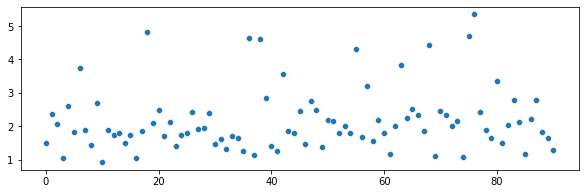

In [ ]:
x = contributors


#ax.set_yscale('log')

In [ ]:
np.median(outs)

1.8941573442218107

In [ ]:
from scipy.stats.mstats import mquantiles_cimj

mquantiles_cimj(data=np.array(outs)/1.5,prob=[0.99],alpha=0.01)

(array([2.61516874]), array([3.63383378]))

In [ ]:
from scipy.stats import bootstrap

def fn(x,axis=None):
  return np.quantile(x,0.99)

data = (outs,)
bootstrap(data,fn,confidence_level=0.9,)
#(1/1.5*np.array(outs)>3).mean()


ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
data = (np.arange(100),)  # samples must be in a sequence
res = bootstrap(data, np.std, confidence_level=0.95,)
res

BootstrapResult(confidence_interval=ConfidenceInterval(low=26.492065998776095, high=31.540994569353888), standard_error=1.2949552047116475)

In [ ]:
np.median(np.array(outs))

1.7626407897632665


w				w u		
k	0.50	0.90	0.95	0.99	0.50	0.90	0.95	0.99
1	0.296	1.118	1.650	2.773	0.117	0.341	0.462	0.727
2	0.763	2.065	2.626	3.893	0.275	0.612	0.753	1.078
3	1.256	2.817	3.428	4.832	0.440	0.843	1.002	1.370
4	1.749	3.522	4.187	5.762	0.601	1.062	1.244	1.626
5	2-255	4.217	4.949	6.602	0.769	1.278	1.467	1.874
10	4.691	7.434	8.392	10.286	1.598	2.285	2.514	3.022
20	9.699	13.429	14.585	17.079	3.251	4.215	4.528	5.186
30	14.712	19.132	20.640	23.348	4.919	6.054	6.429	7.187
40	19.649	24.799	26.397	29.803	6.584	7.891	8.283	9.179
50	24.643	30.446	32.175	35.680	8.236	9.703	10.134	11.018


In [ ]:
kpss(counter[:10000])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.24262175169429234,
 0.1,
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

/usr/local/lib/python3.8/dist-packag

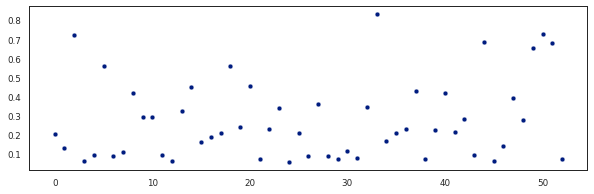

In [ ]:
x = counter

N_WINDOW = 10000

x_block=np.resize(x,(len(x)//N_WINDOW,N_WINDOW))

def fn(x):
  return np.var(x)

outs = np.apply_along_axis(kpss_robust,1,x_block)

fig,ax = plt.subplots()
sns.scatterplot(x=np.arange(len(outs)),y=outs,ax=ax)
#ax.set_yscale('log')

In [ ]:
adfuller(counter[10000:20000],maxlag=10)
#(counter[20000:30000])
#kpss_robust(counter)

(-101.57339704743735,
 0.0,
 0,
 9999,
 {'1%': -3.4310041633725734,
  '5%': -2.861829101294412,
  '10%': -2.566923883481157},
 30936.418381778116)

In [ ]:
%%R
x <- seq(0, 4, length.out=100)
alpha <- 1:5

plot(x, xlim=c(0, 4), ylim=c(0, 10), 
     xlab='x', ylab=TeX(r'($\alpha  x^\alpha$, where $\alpha \in \{1 \ldots 5\}$)'), 
     type='n', main=TeX(r'(Using $\LaTeX$ for plotting in base graphics!)', bold=TRUE))

for (a in alpha) {
  lines(x, a*x^a, col=a)
}

legend('topleft', 
       legend=TeX(sprintf(r'($\alpha = %d$)', alpha)), 
       lwd=1, 
       col=alpha)


NotImplementedError: ignored

In [ ]:
(outs>0.739).mean()

#from scipy.stats.mstats import mquantiles
#mquantiles(outs,0.95)

0.018867924528301886

In [ ]:
np.quantile(outs,0.99)

0.5108799340887727

In [ ]:
from scipy.stats.mstats import hdquantiles_sd
hdquantiles_sd(outs,0.99)

masked_array(data=[0.02843319],
             mask=False,
       fill_value=1e+20)

In [ ]:
#mask = (counter<=240) & (counter >= 232)
#kpss(counter[mask])
#adfuller(np.diff(counter),maxlag=10)
#kpss(counter[-10000:])

In [ ]:
from scipy.stats import bartlett
from scipy.stats import levene

levene(counter[:100000],counter[100000:])

LeveneResult(statistic=13.626429694078544, pvalue=0.0002230455521386568)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LeveneResult(statistic=nan, pvalue=nan)

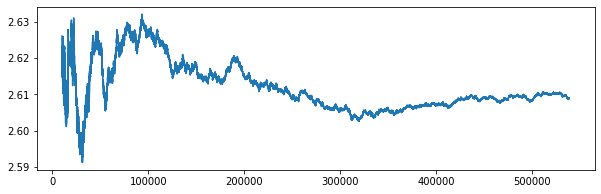

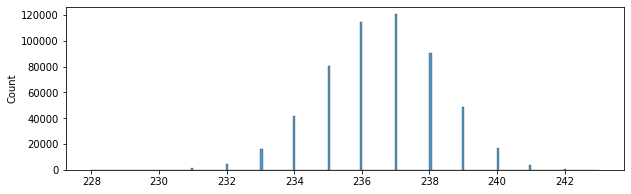

In [ ]:
sns.histplot(bits.sum(1))

no-correlation (pearsonr): p-val=0.016273176063260838
next-bit independent (chi2): p-val=0.016394835015046953


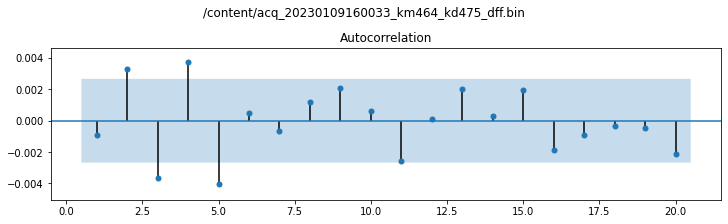

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fname = "/content/acq_20230109160033_km464_kd475_dff.bin"
KM = 464
KD = 475
bits = read_dff(fname,KM=KM,KD=KD)
bits = bits.astype('int32')
counter = bits.sum(1)
x = counter%2

fig,ax = plt.subplots(1,1,constrained_layout=True)
fig = plot_acf(x=x, lags = 20, fft=True, alpha=0.05, bartlett_confint=True, zero=False, adjusted=True, ax=ax, auto_ylims=True)
fig.suptitle(f'{fname}')

from scipy.stats import pearsonr
_,pval = pearsonr(x[2:],x[:-2])
print(f'no-correlation (pearsonr): p-val={pval}')

from scipy.stats import chi2_contingency
cross_tab = pd.crosstab(x[2:],x[:-2])
_,pval,_,_ = chi2_contingency(cross_tab)
print(f'next-bit independent (chi2): p-val={pval}')

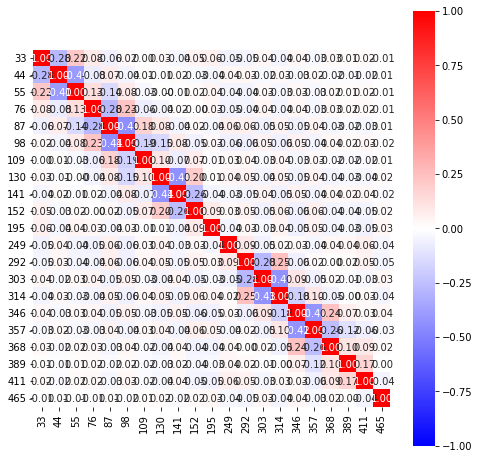

In [ ]:
ps = bits.mean(0)
good_idxs = np.arange(len(ps))[(ps > 0.05) & (1-ps > 0.05)]
good_bits = bits[:,good_idxs]
corr_matrix = np.corrcoef(good_bits.T)

fig,ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr_matrix,cmap='bwr',
            vmin=-1,vmax=1,
            xticklabels=good_idxs,yticklabels=good_idxs,
            square=True,annot=True,fmt=".2f",
            ax=ax)

plt.show()

In [ ]:
filename = '/content/Spartan6/Spartan6/card_7/b_2/acq_20230109160033_km464_kd475_dff_rng_nist_1bit.bin'
x = np.fromfile(filename, dtype="uint8") # read bytes
#bits_data = np.unpackbits(bytes_data, axis=None, count=None, bitorder='little') # unpack to bits

no-correlation (pearsonr): p-val=0.0005986535824731223
next-bit independent (chi2): p-val=0.0006030968257569408


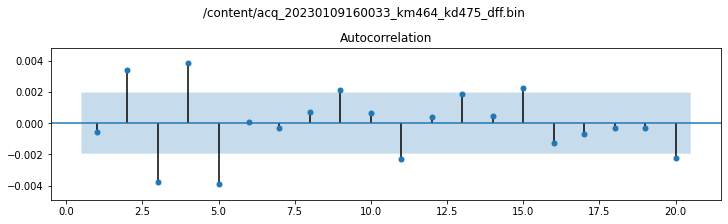

In [ ]:
fig,ax = plt.subplots(1,1,constrained_layout=True)
fig = plot_acf(x=x, lags = 20, fft=True, alpha=0.05, bartlett_confint=True, zero=False, adjusted=True, ax=ax, auto_ylims=True)
fig.suptitle(f'{fname}')

from scipy.stats import pearsonr
_,pval = pearsonr(x[2:],x[:-2])
print(f'no-correlation (pearsonr): p-val={pval}')

from scipy.stats import chi2_contingency
cross_tab = pd.crosstab(x[2:],x[:-2])
_,pval,_,_ = chi2_contingency(cross_tab)
print(f'next-bit independent (chi2): p-val={pval}')

In [ ]:
x.mean()

0.500975

In [ ]:
chi2_contingency(cross_tab)

(5.760025381473694,
 0.016394835015046953,
 1,
 array([[134091.02431974, 134734.97568026],
        [134735.97568026, 135383.02431974]]))

In [ ]:
(cross_tab/cross_tab.sum(1))

col_0         0         1
row_0                    
0      0.500443  0.497166
1      0.499561  0.502830

In [ ]:
np.savetxt('wrong_trng.txt',out.astype(int))

In [ ]:
s=4428
n=500000
p = math.erfc(float(s)/(math.sqrt(float(n)) * math.sqrt(2.0))) #p-value
p

3.797354919238374e-10

In [ ]:
import math

def test(input, n):
  ones = (input==1).sum() #number of ones
  zeroes = (input==0).sum()    #number of zeros
  s = abs(ones - zeroes)  
  p = math.erfc(float(s)/(math.sqrt(float(n)) * math.sqrt(2.0))) #p-value
  success = ( p >= 0.01)  # success = true if p-value >= 0.01
  return [zeroes, ones, s, p, success]

test(out,len(out))

[268827, 270120, 1293, 0.0781930185868285, True]

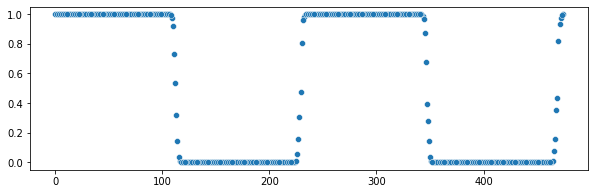

In [ ]:
ps = bits.mean(0)
idx = np.arange(KD)*KM%KD
sns.scatterplot(x=idx,y=ps)

In [ ]:
acf(counter%2,adjusted=True, bartlett_confint=True,alpha=0.05,qstat=True,nlags=5)

(array([ 1.00000000e+00, -9.07512234e-04,  3.27289960e-03, -3.63136755e-03,
         3.71823930e-03, -4.03215969e-03]),
 array([[ 1.00000000e+00,  1.00000000e+00],
        [-3.57728969e-03,  1.76226522e-03],
        [ 6.03119942e-04,  5.94267925e-03],
        [-6.30117580e-03, -9.61559293e-04],
        [ 1.04839584e-03,  6.38808276e-03],
        [-6.70204006e-03, -1.36227932e-03]]),
 array([ 0.44386761,  6.21704161, 13.32411016, 20.77529894, 29.5377811 ]),
 array([5.05261609e-01, 4.46669776e-02, 3.98563570e-03, 3.50861120e-04,
        1.81827584e-05]))

In [ ]:
pvals

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acf_vals,confs,_,pvals=acf(counter%2,nlags=10,qstat=True,alpha=0.05)

sns.scatterplot(x=np.arange(11),y=acf_vals)
#acf(counter,nlags=10,)

In [ ]:
pvals.round(2)

In [ ]:
len(acf_vals)

In [ ]:
pd.get_dummies(counter).cumsum().plot()

In [ ]:
def get_stationarity_tests(bytes_data, nlags=10, alpha=0.05, postprocess_fn=last_bit):
  """ Analyze dependencies of TRNG bytes candidate.
      Args:
          bytes_data (pandas.DataFrame): series of raw bytes (das), encoded as integers uint8
          nlags (int): maximum number of lags to analyse
          alpha (float): confidence level for hypothesis testing
          postprocess_fn (function): transform applied to the series. For example, use <mod 2> to extract the last significant bit
      Return:
          figure: picture with plots
  """
  params = {
        'lags':nlags,
        'alpha':alpha,
        'postprocess_fn':postprocess_fn.__name__
  }
  mlflow.log_params(params)
  fig,axs = plt.subplots(1,2,constrained_layout=True)
  # plot histogram
  ax = axs[0]
  sns.histplot(data=bytes_data,x='byte value',ax=ax,discrete=True)
  # plot time series
  ax = axs[1]
  sns.lineplot(data=bytes_data.loc[:1000],x='timestep',y='byte value',ax=ax)
  plt.show()
  mlflow.log_figure(fig,'exploratory.png')
  bytes_data = postprocess_fn(bytes_data)
  # descriptive stats
  if postprocess_fn==counter_val:
    mlflow.log_metric('mean',bytes_data.mean())
  # stationarity tests on postprocessed data
  results = kpss(bytes_data,nlags=10)
  pval = results[1]
  mlflow.log_metric(f'stationary.KPSS.lag_{nlags}',pval)
  results = adfuller(bytes_data,maxlag=10)
  pval = results[1]
  mlflow.log_metric(f'not-stationary.ADF.lag_{nlags}',pval)
  # plot autocorelation by 
  fig,ax = plt.subplots(1,1,constrained_layout=True)
  fig = plot_acf(x=bytes_data, lags = nlags, fft=True, alpha=alpha, bartlett_confint=True, zero=False, adjusted=True, ax=ax, auto_ylims=True)
  ax.set(xlabel='Lag',ylabel='Corr')
  plt.show()
  mlflow.log_figure(fig,'autocorrelation.png')
  # find p-values for autocorrelation
  _,_,_,pvals = acf(
          x=bytes_data,
          nlags=nlags,
          alpha=alpha,
          fft=True,
          bartlett_confint=True,
          adjusted=True,
          qstat=True
  )
  pvals = {'lag':np.arange(1,nlags+1),'Ljung-Box Test p-val':pvals}
  pvals = pd.DataFrame(data=pvals)
  pvals.set_index('lag',inplace=True)
  display(pvals)
  mlflow.log_metric(f'not-correlated.LjungBox.lag_{nlags}',pvals.loc[nlags])

## Intra Correlations

# Individual Patterns

INFO:TRNG Analysis:Doing experiment CV_M1___B2_no_constraints with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment CV_M2___B2_no_constraints with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment CV_M2___C2_no_constraints with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment CV_M2___A1_no_constraints with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matpl

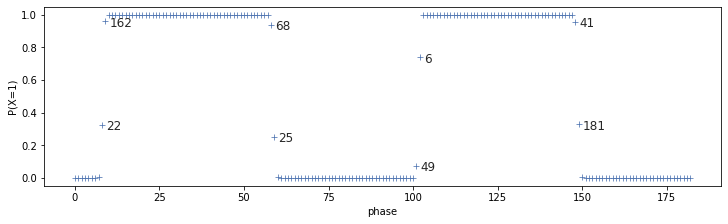

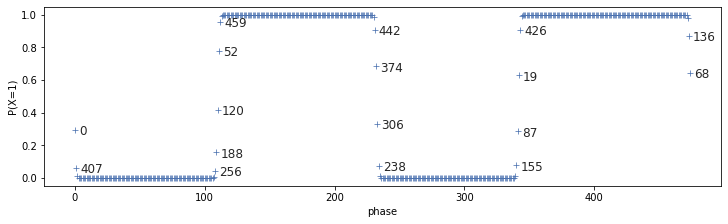

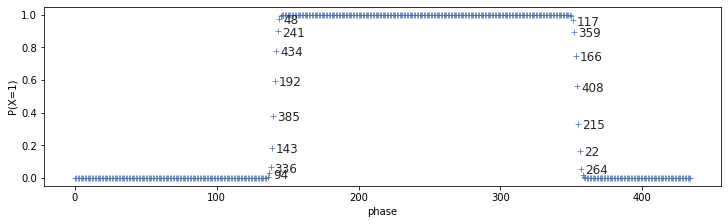

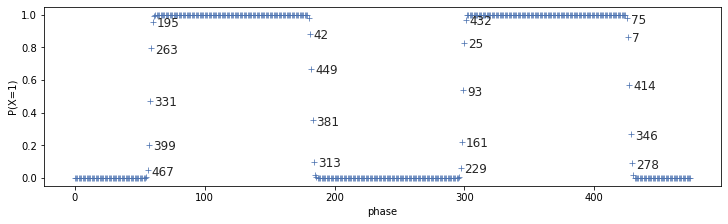

INFO:TRNG Analysis:Doing experiment CV_M1___C1_no_constraints with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment CV_M2___A2_no_constraints with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
INFO:TRNG Analysis:Doing experiment CV_M1___A2_no_constraints with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
INFO:TRNG Analysis:Doing experiment CV_M1___C2_no_constraints with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matpl

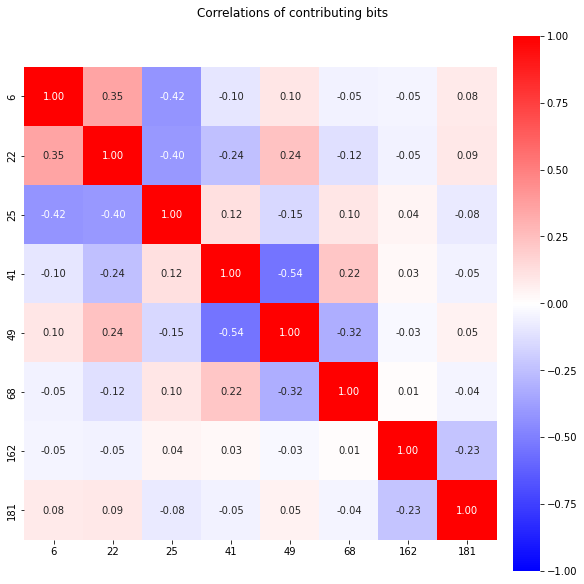

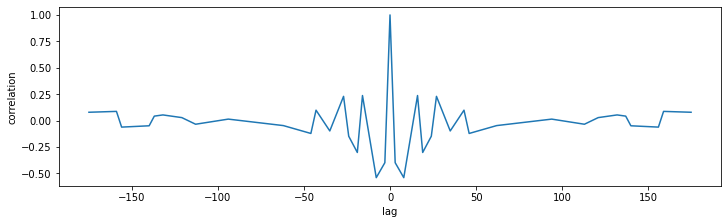

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


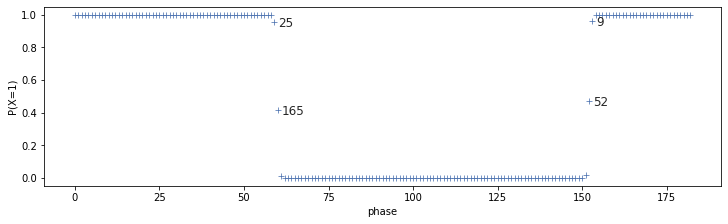

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


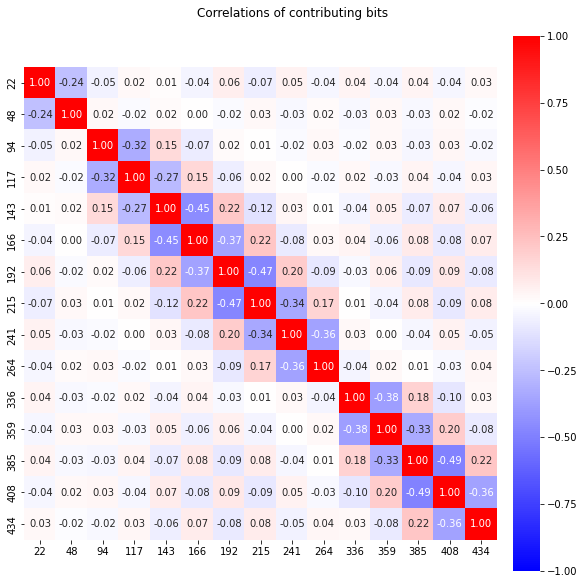

INFO:TRNG Analysis:Doing experiment CV_M1___B1_no_constraints with params {'bit_pdf': True, 'bits_intra_correlation': True}


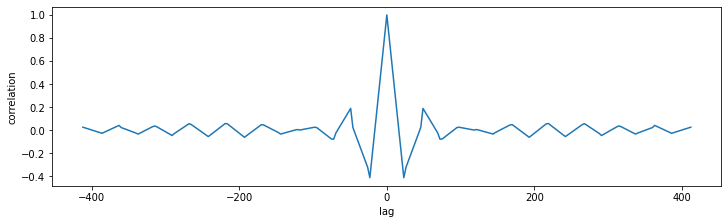

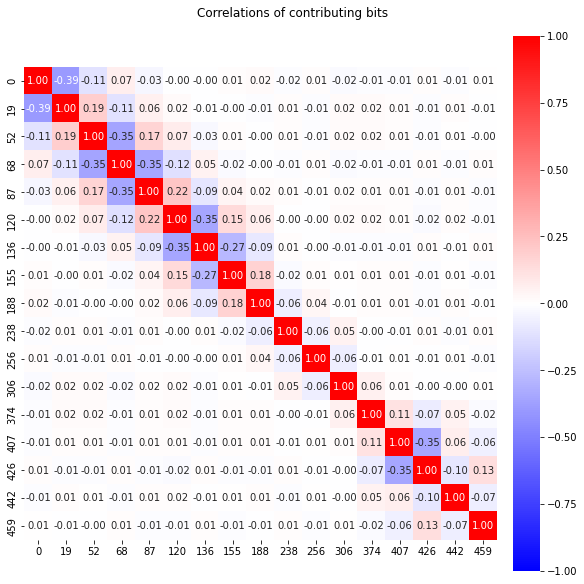

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


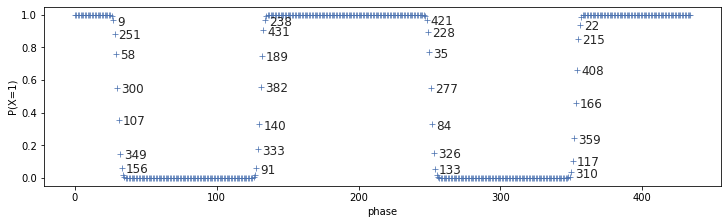

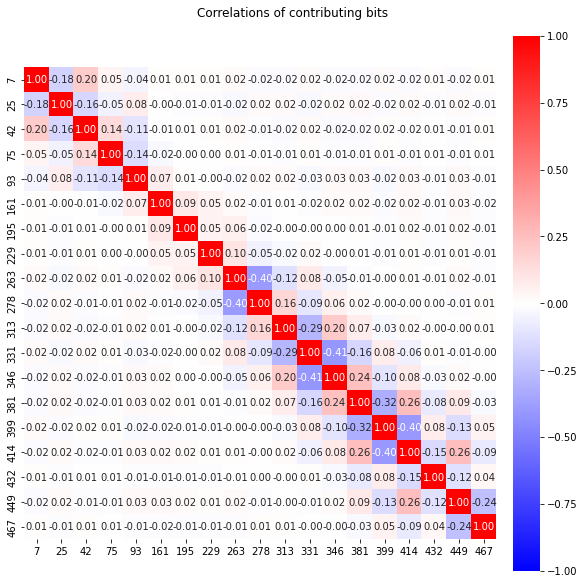

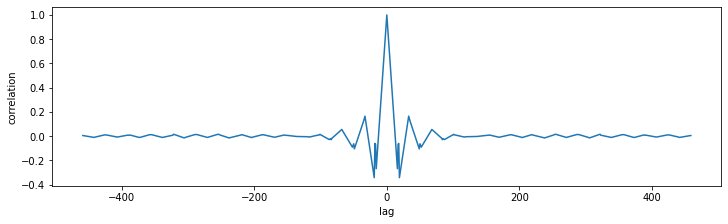

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


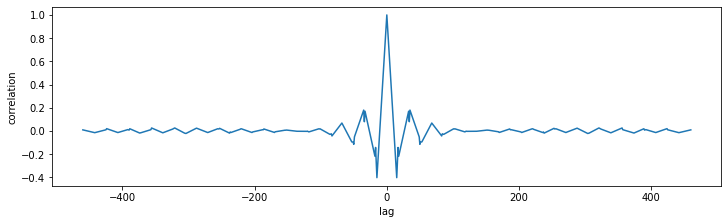

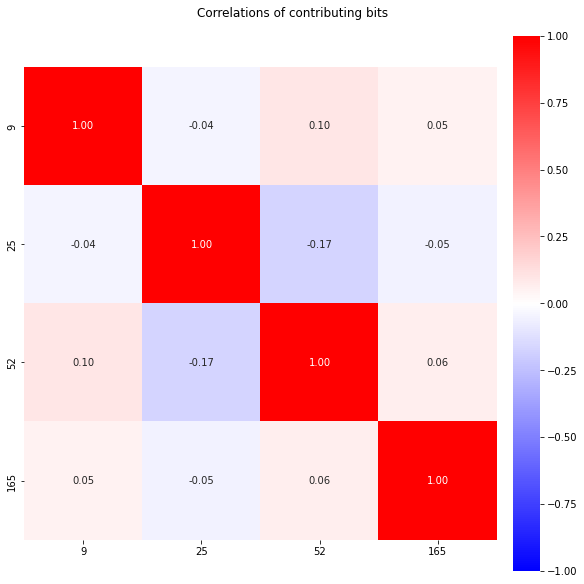

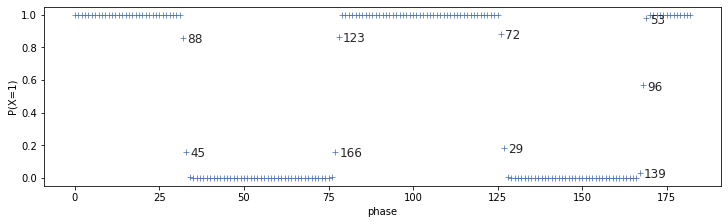

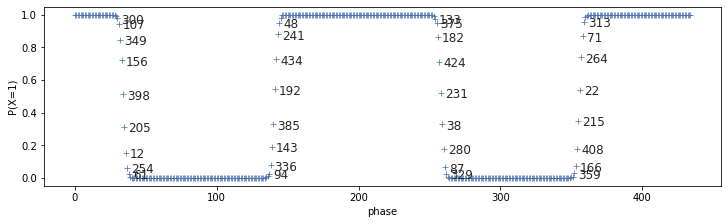

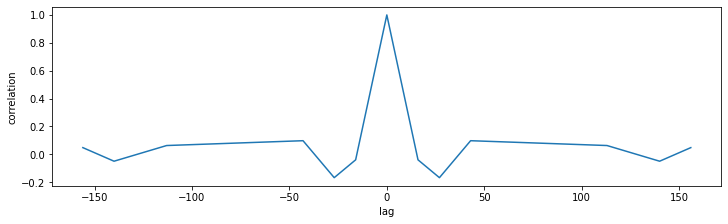

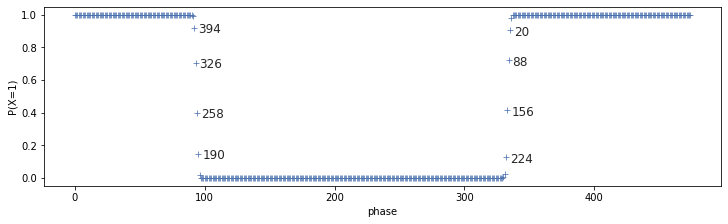

INFO:TRNG Analysis:Doing experiment CV_M2___C1_no_constraints with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment CV_M1__C1_global with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment CV_M1___A1_no_constraints with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarni

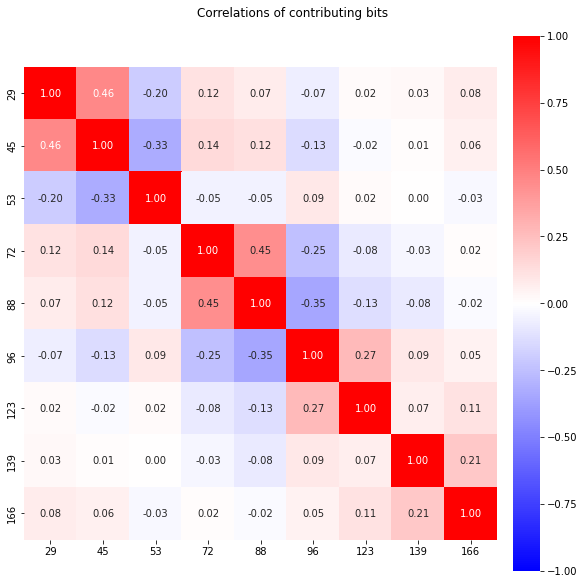

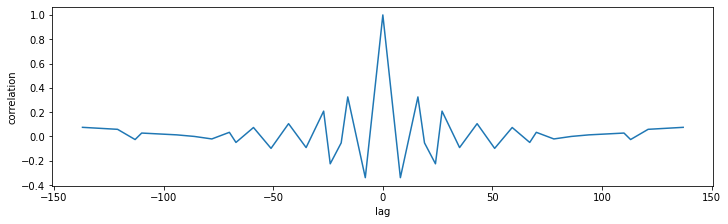

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


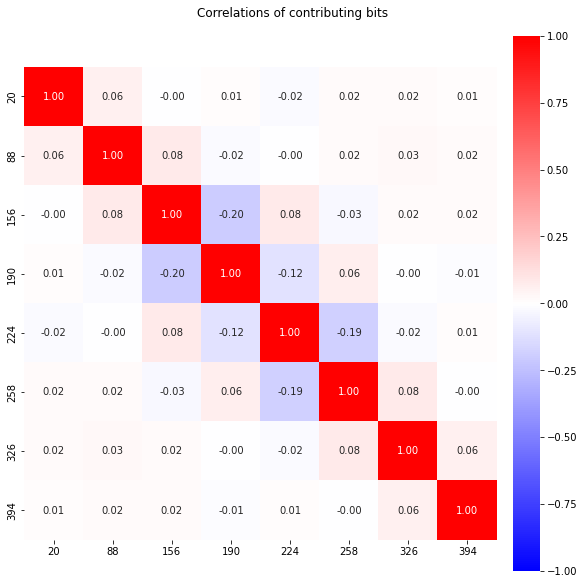

INFO:TRNG Analysis:Doing experiment CV_M2___B1_no_constraints with params {'bit_pdf': True, 'bits_intra_correlation': True}


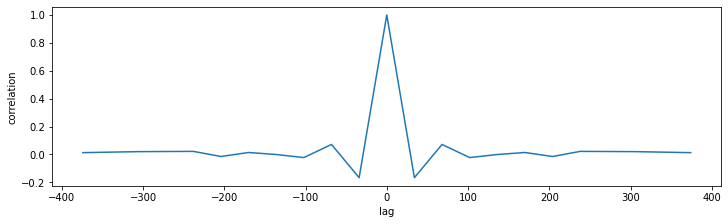

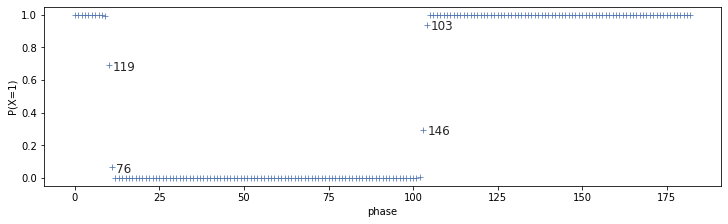

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


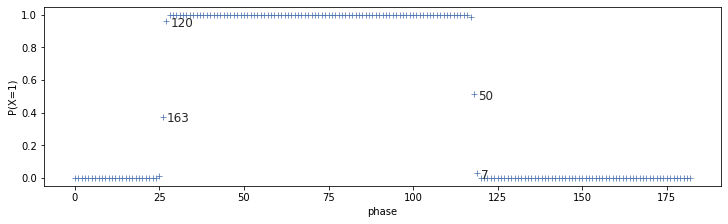

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
INFO:TRNG Analysis:Doing experiment CV_M2__B1_global with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
INFO:TRNG Analysis:Doing experiment CV_M1__A2_global with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/pytho

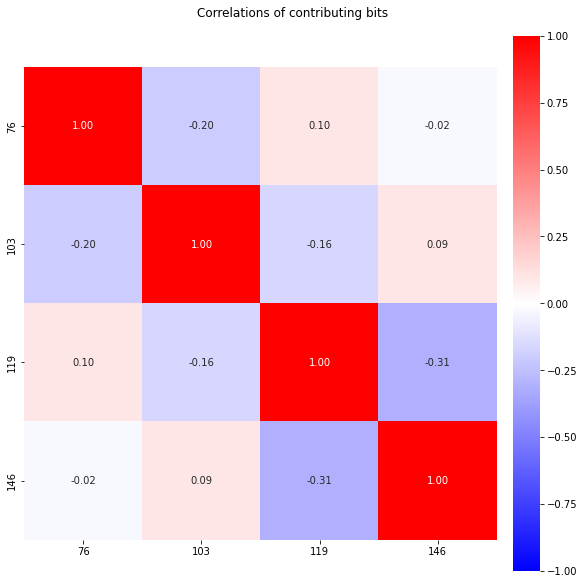

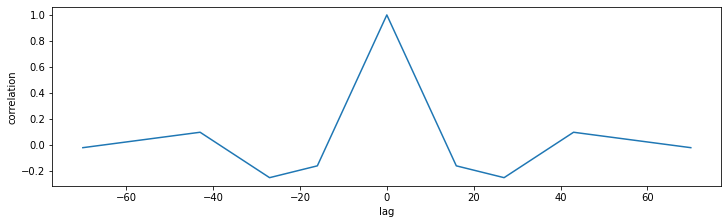

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


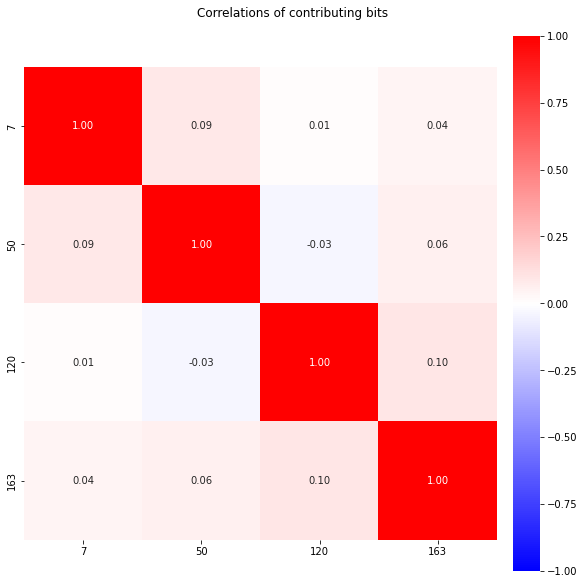

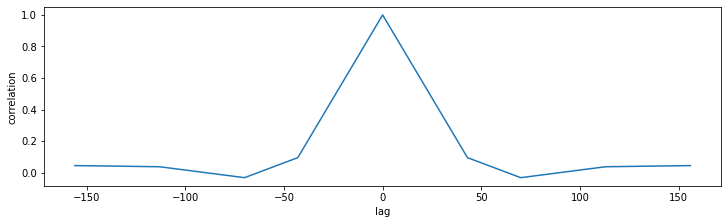

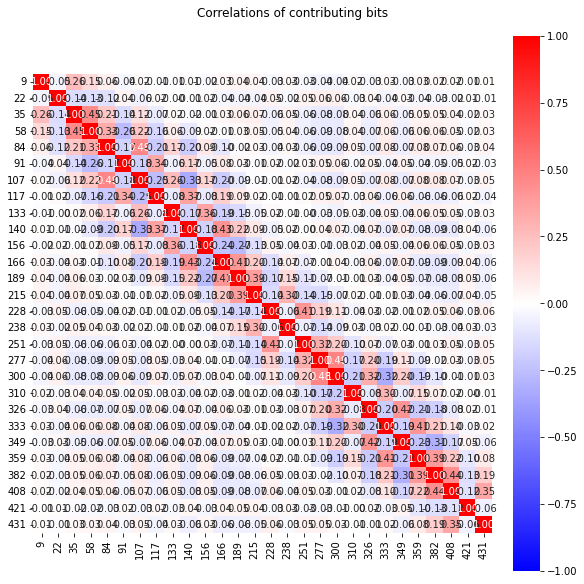

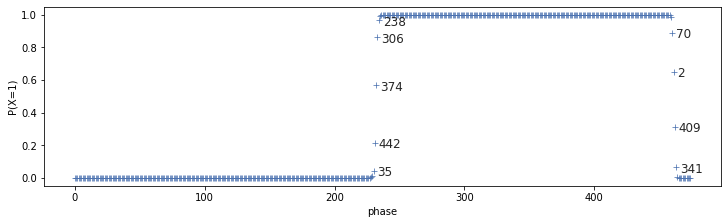

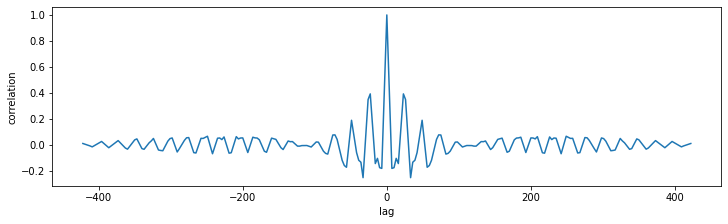

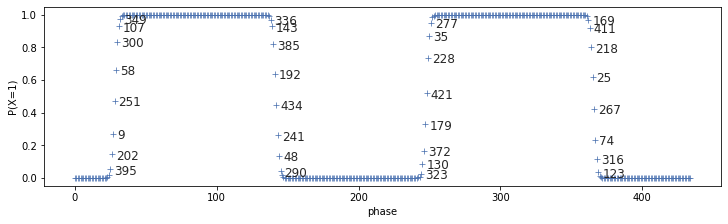

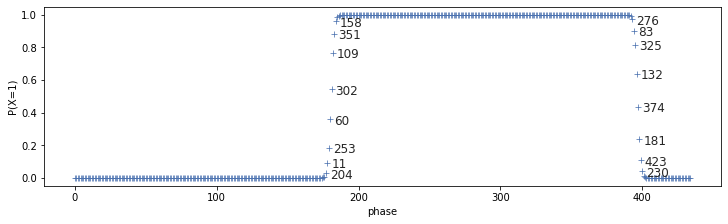

INFO:TRNG Analysis:Doing experiment CV_M2__C1_global with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
INFO:TRNG Analysis:Doing experiment CV_M2__C2_global with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


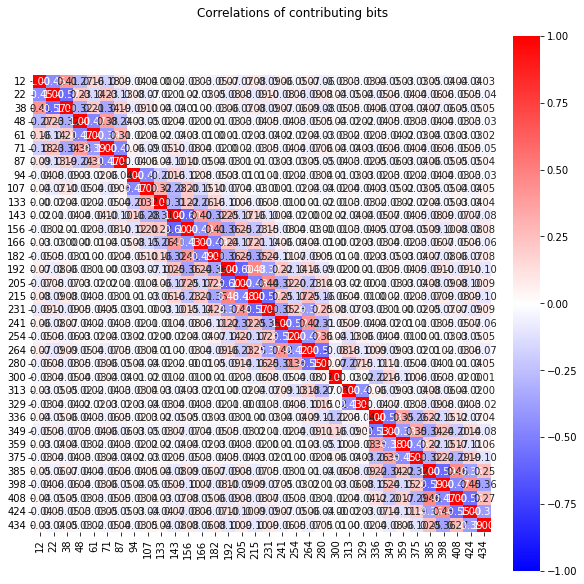

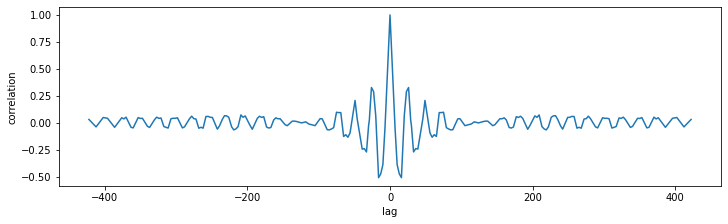

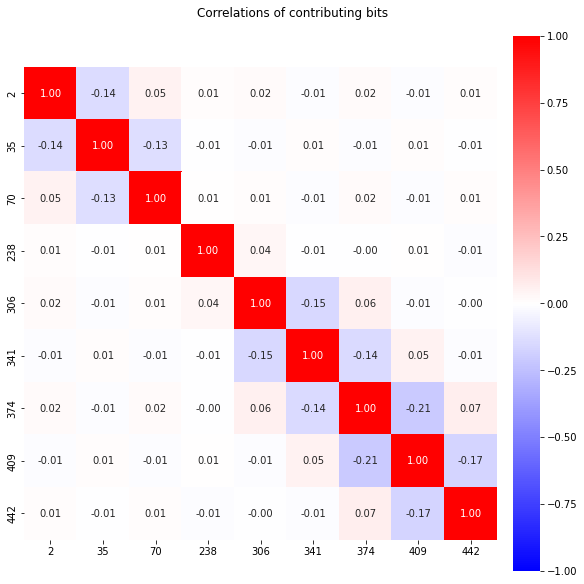

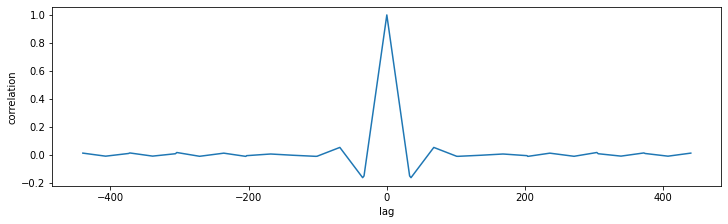

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


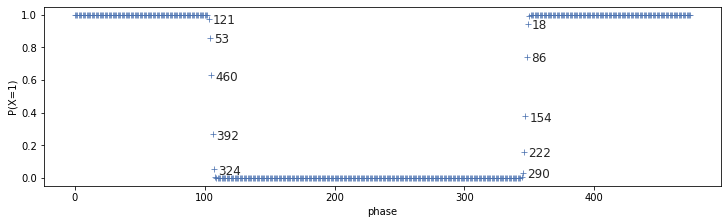

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


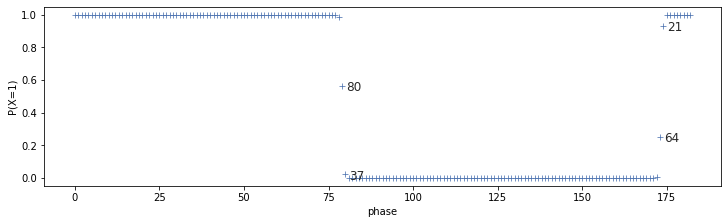

INFO:TRNG Analysis:Doing experiment CV_M2__B2_global with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment CV_M2__A2_global with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
INFO:TRNG Analysis:Doing experiment CV_M1__B2_global with params {'bit_pdf': True, 'bits_intra_correlation': True}


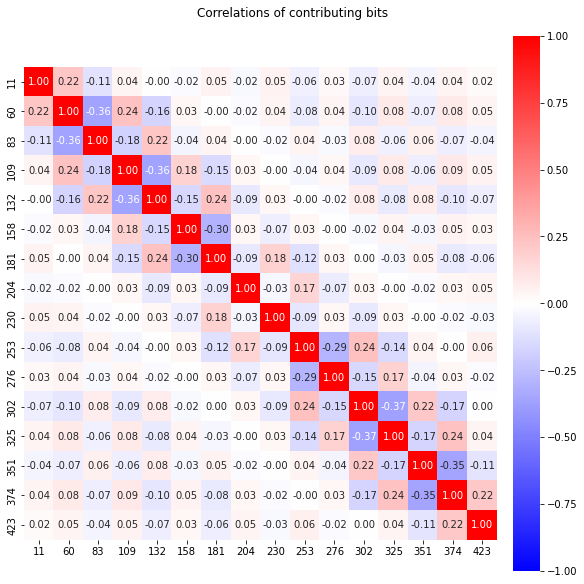

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


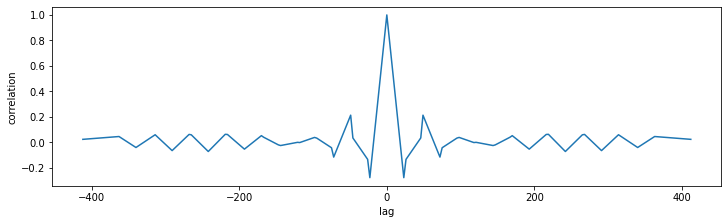

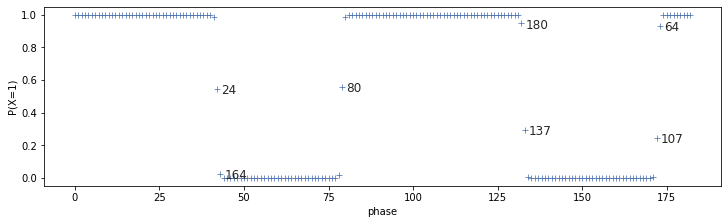

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


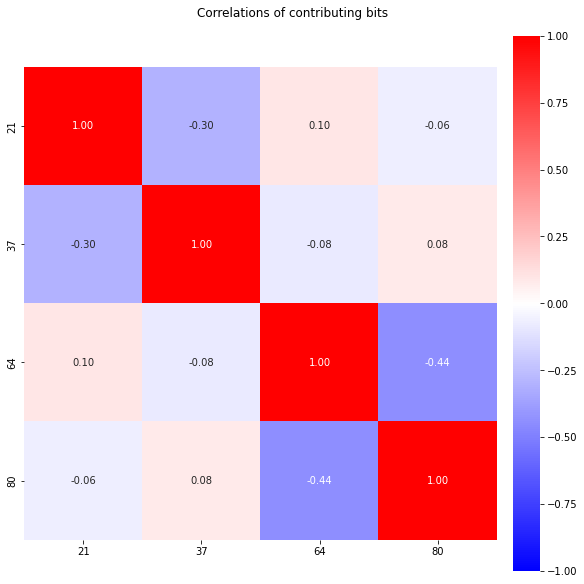

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


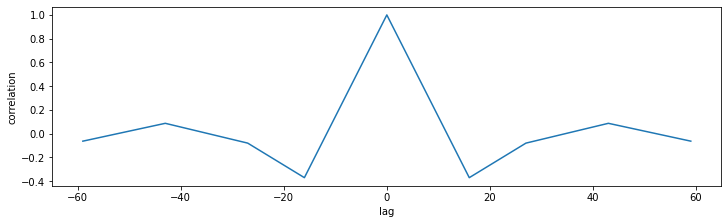

INFO:TRNG Analysis:Doing experiment CV_M2__A1_global with params {'bit_pdf': True, 'bits_intra_correlation': True}


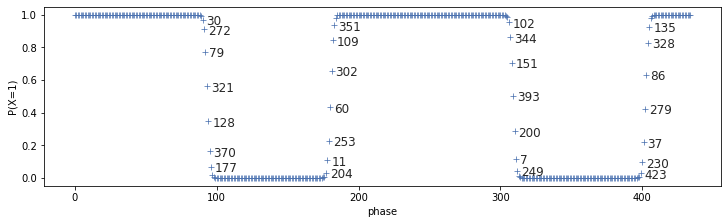

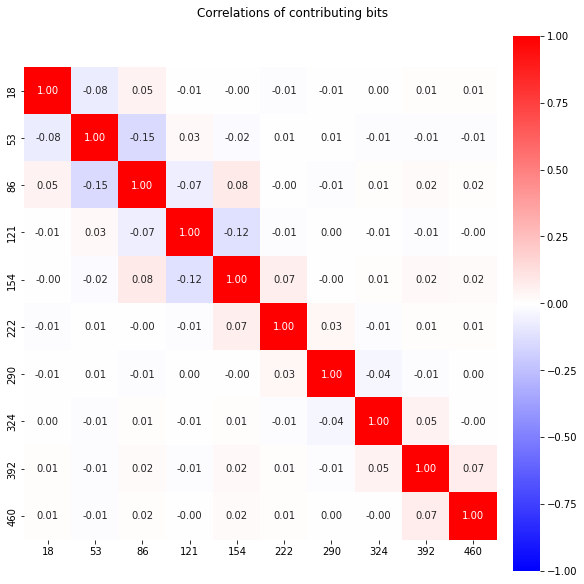

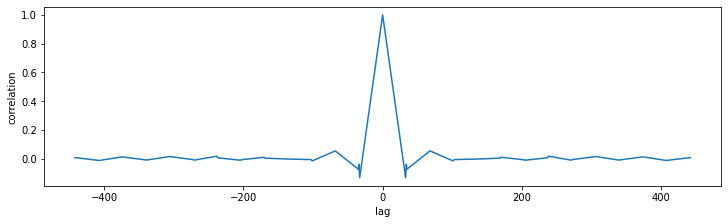

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


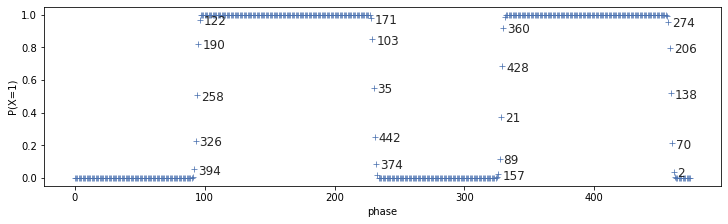

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


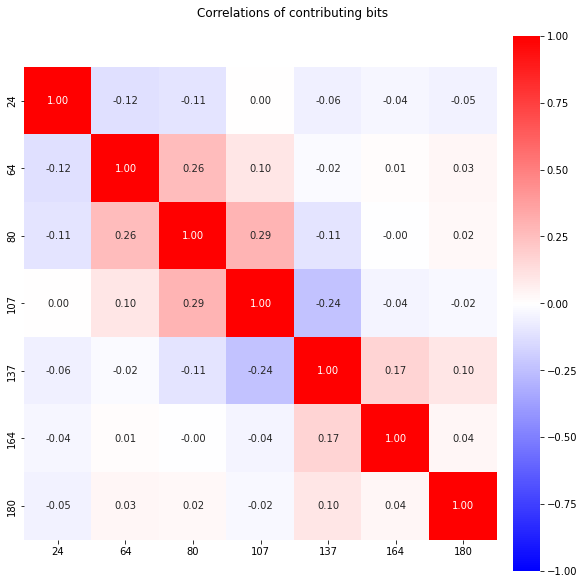

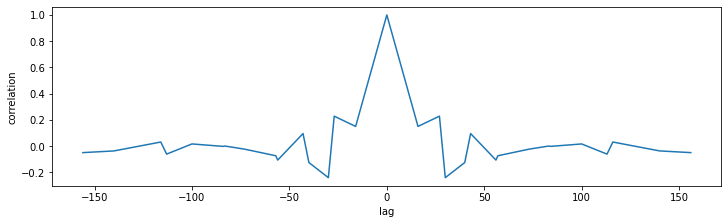

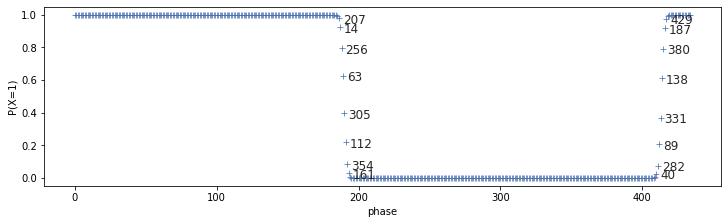

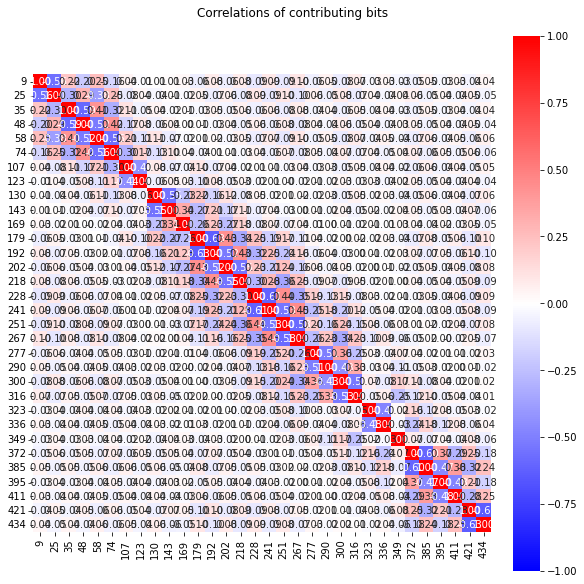

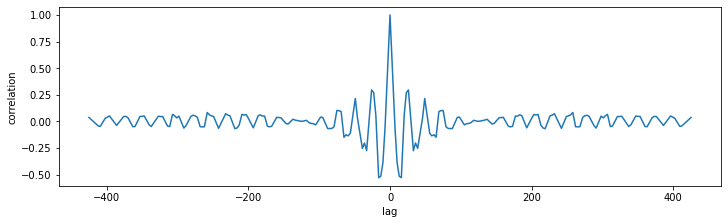

INFO:TRNG Analysis:Doing experiment CV_M1__B1_global with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment CV_M2_B1_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}


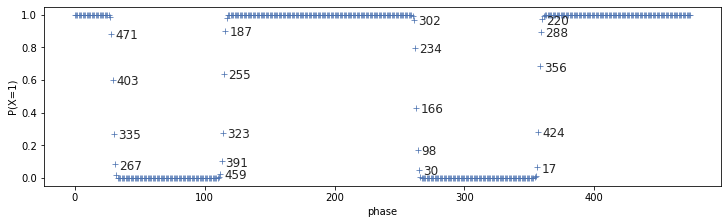

INFO:TRNG Analysis:Doing experiment CV_M1__C2_global with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotl

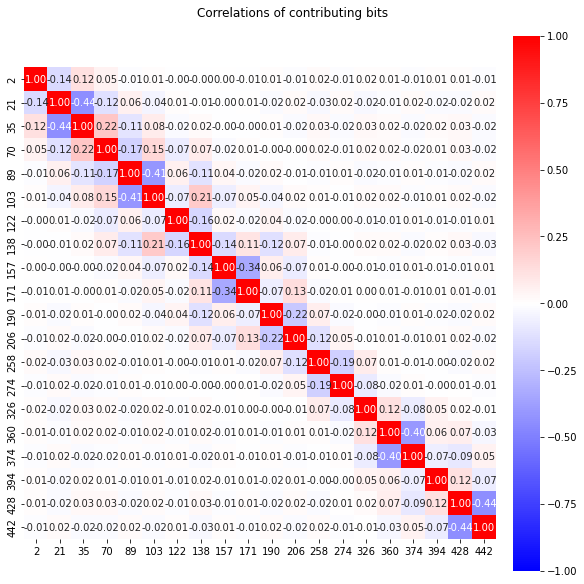

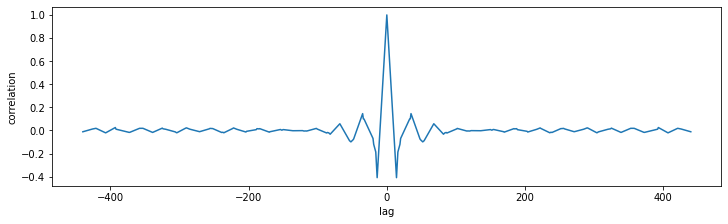

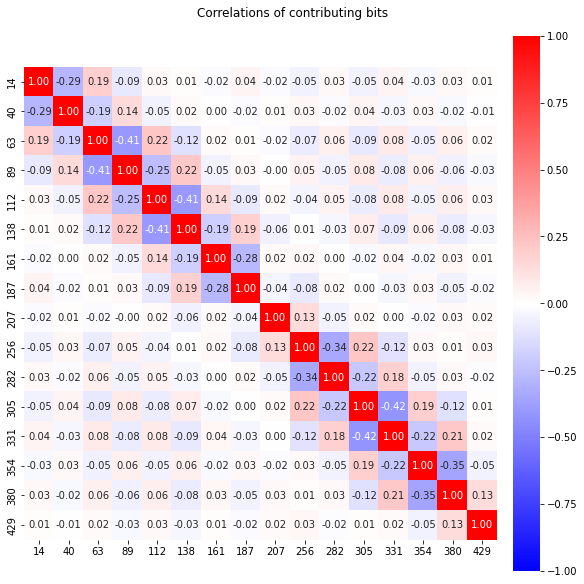

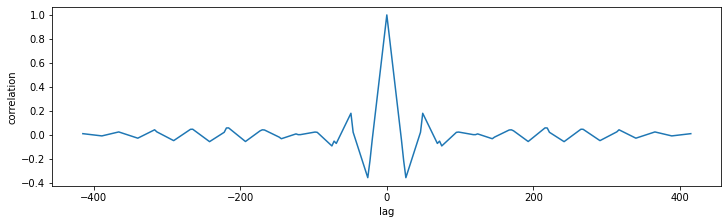

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


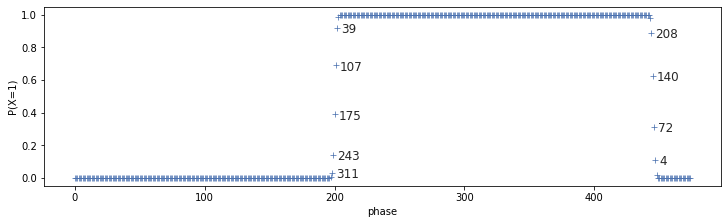

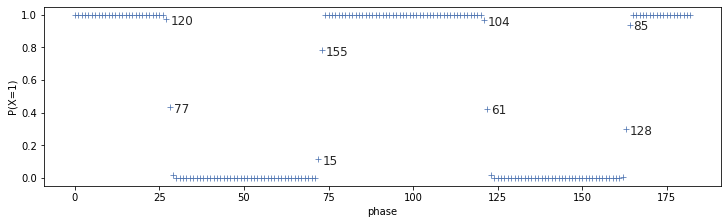

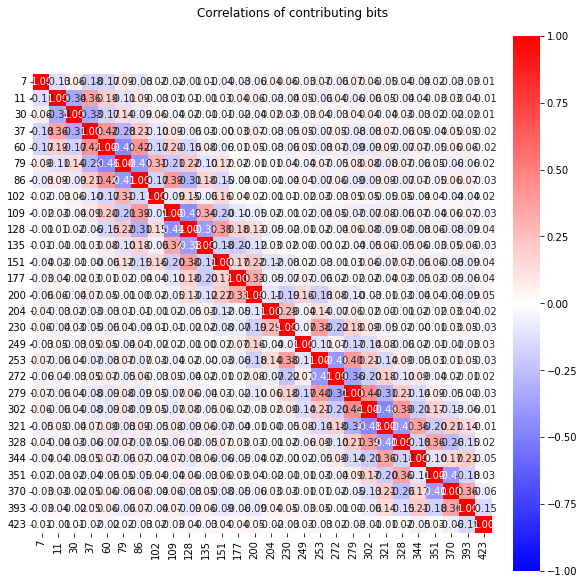

INFO:TRNG Analysis:Doing experiment CV_M1__A1_global with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment CV_M1_A2_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}


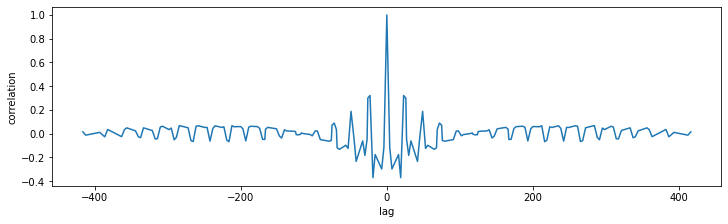

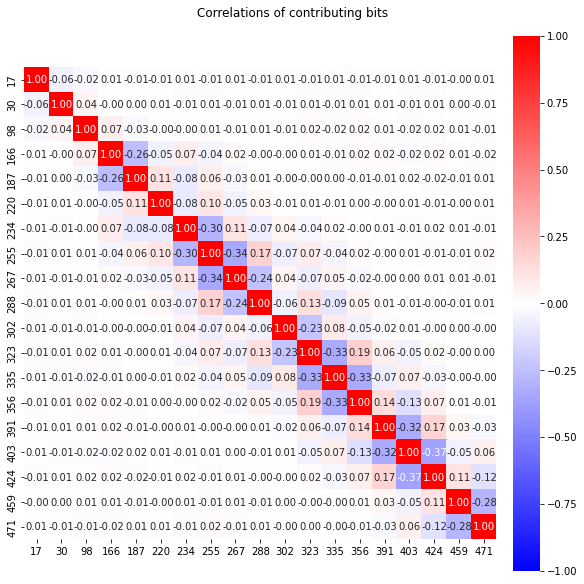

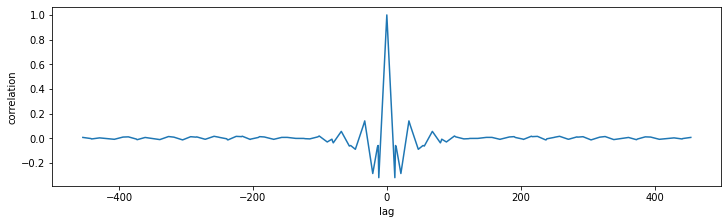

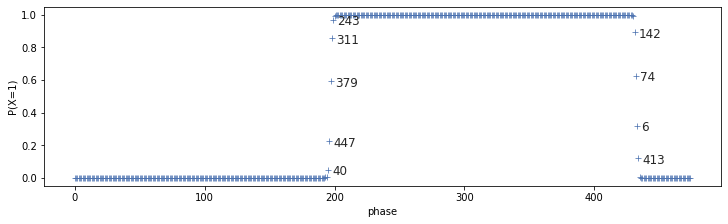

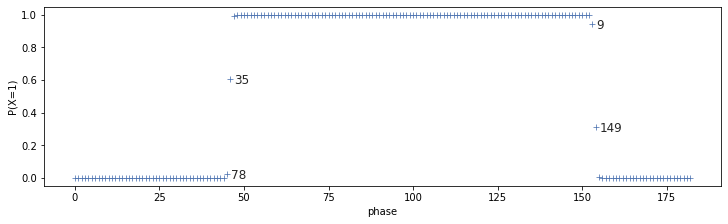

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
INFO:TRNG Analysis:Doing experiment CV_M1_C1_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}


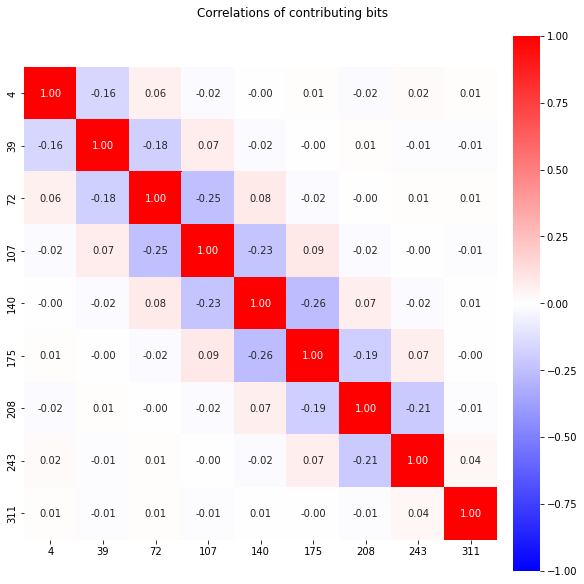

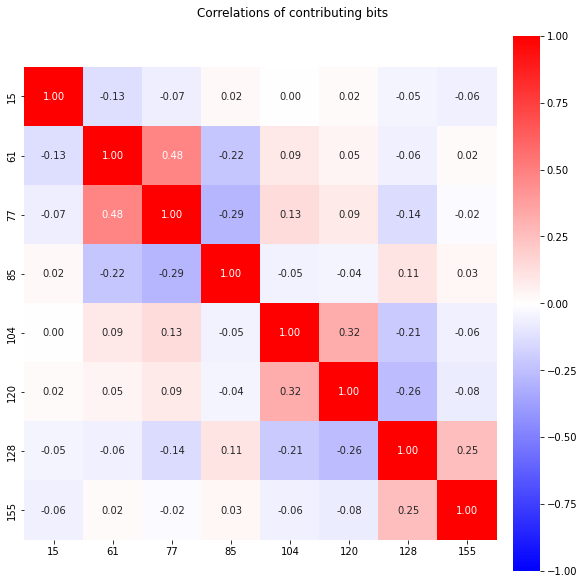

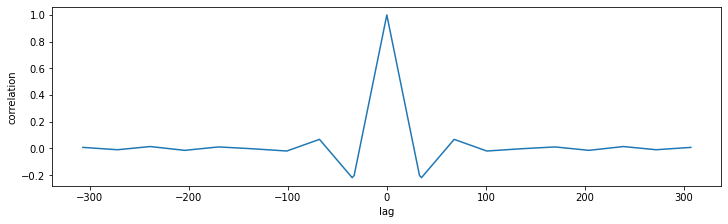

INFO:TRNG Analysis:Doing experiment CV_M2_A1_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}


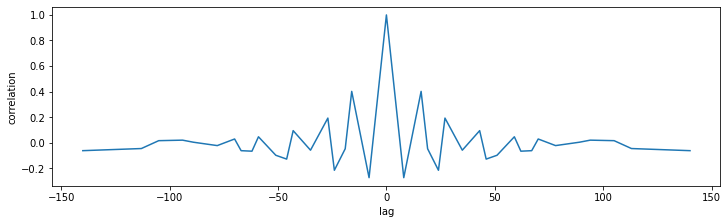

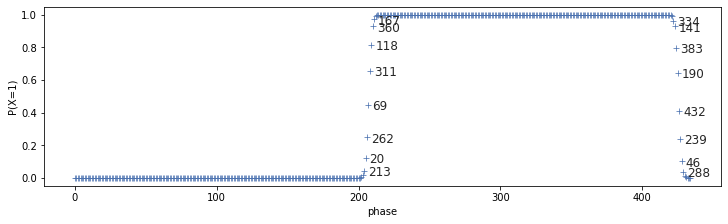

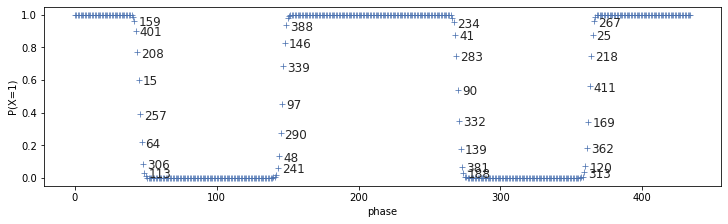

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


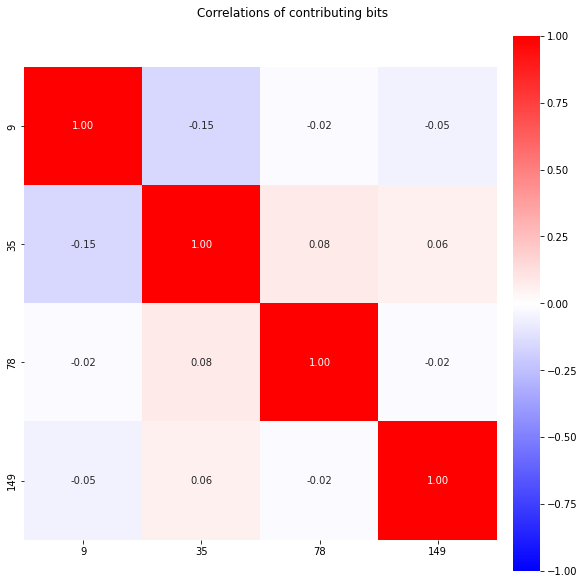

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


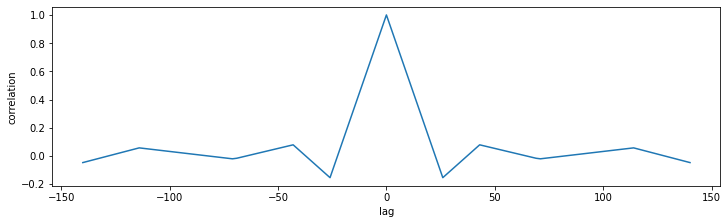

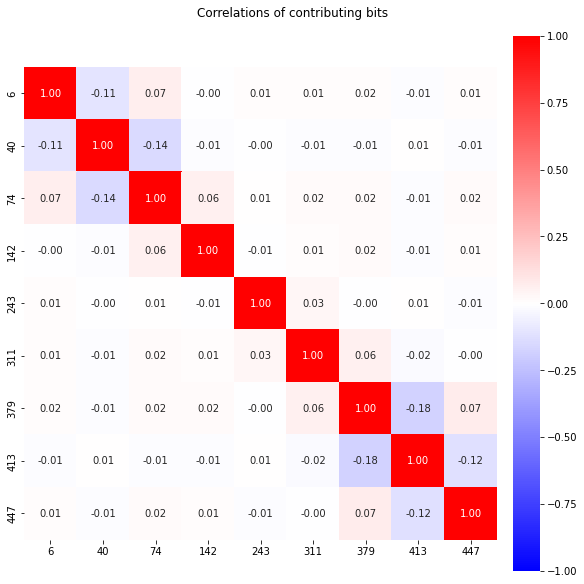

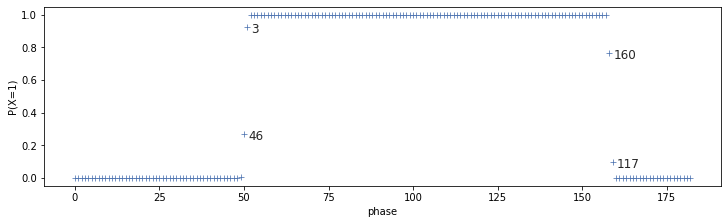

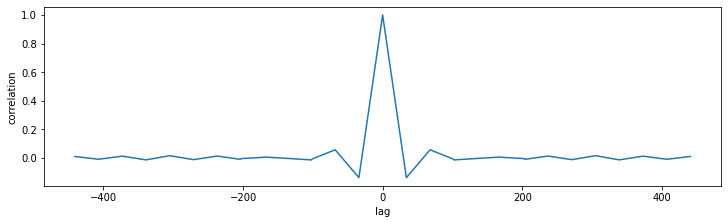

INFO:TRNG Analysis:Doing experiment CV_M2_B2_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}


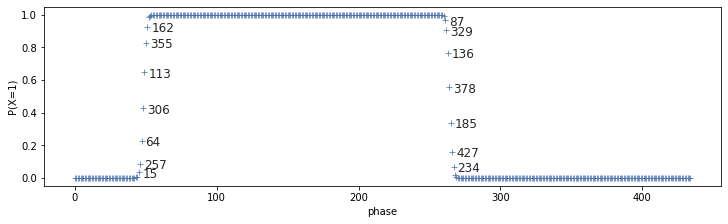

INFO:TRNG Analysis:Doing experiment CV_M1_C2_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
INFO:TRNG Analysis:Doing experiment CV_M1_B2_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
INFO:TRNG An

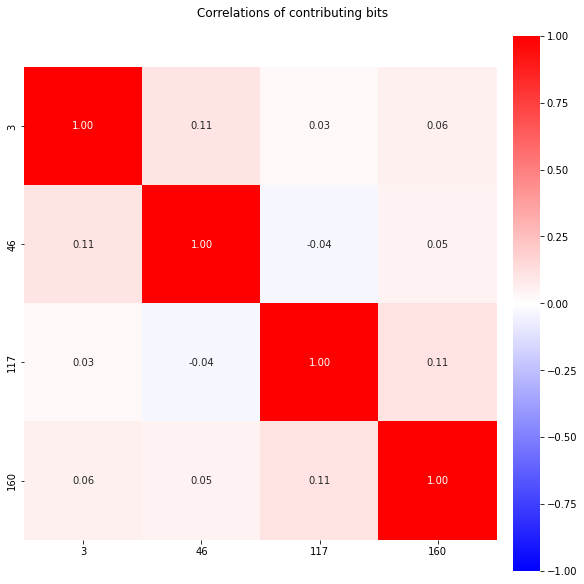

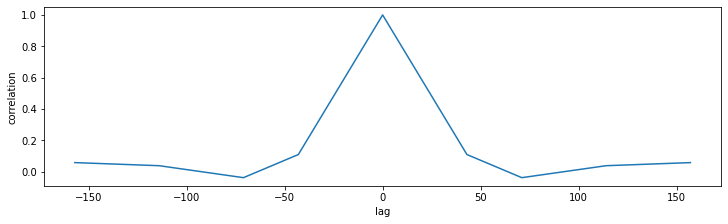

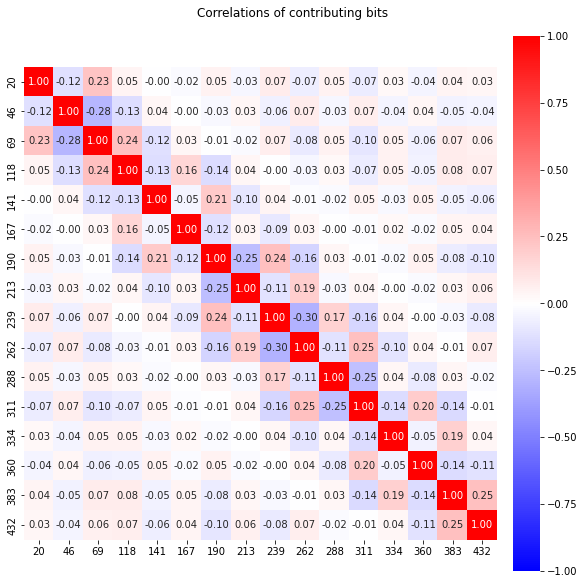

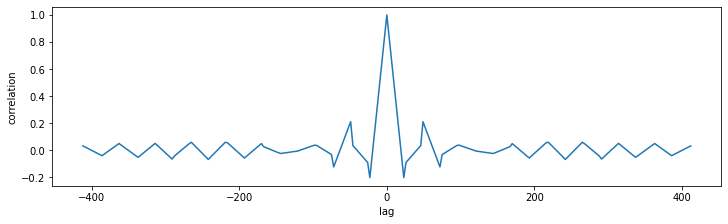

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


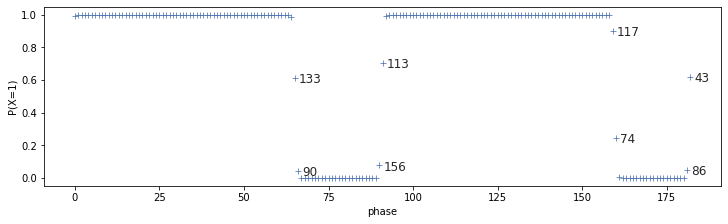

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


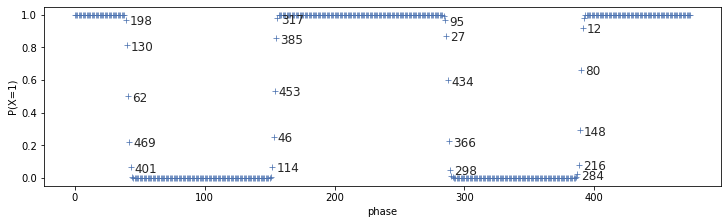

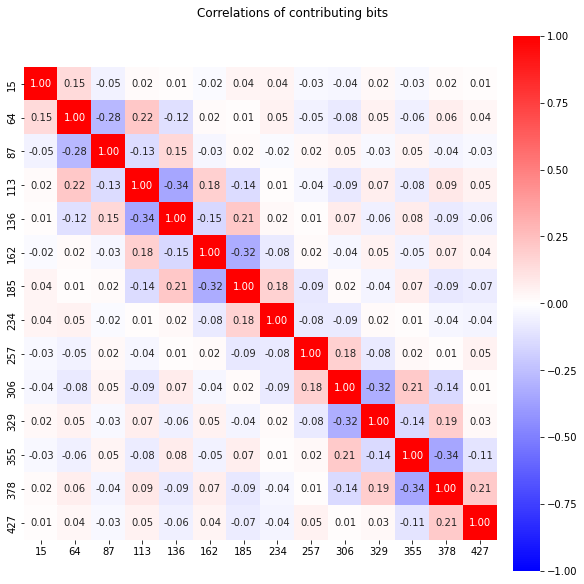

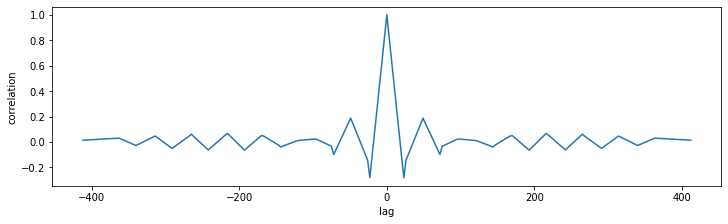

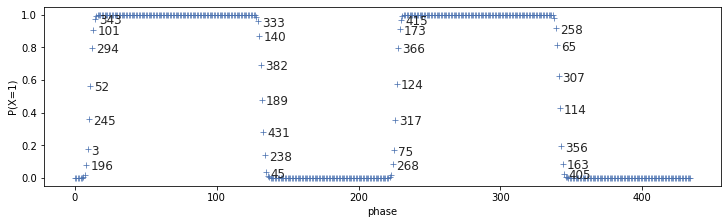

INFO:TRNG Analysis:Doing experiment CV_M2_C2_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


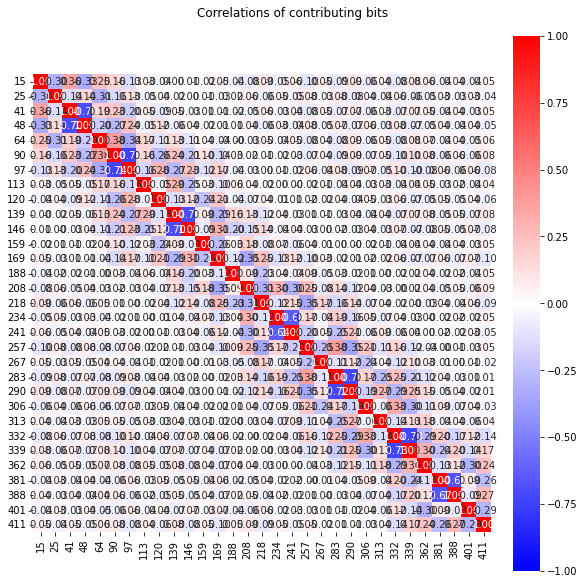

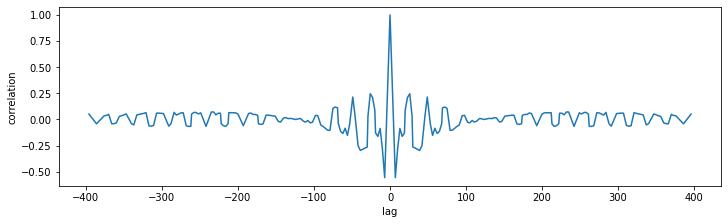

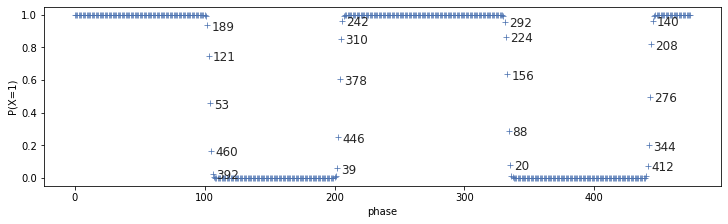

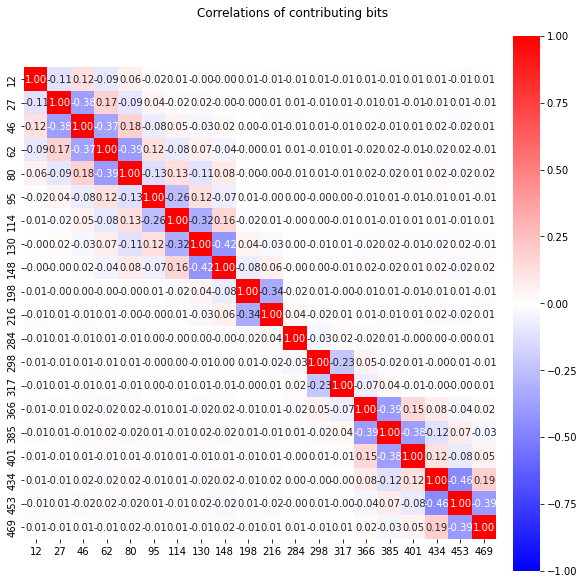

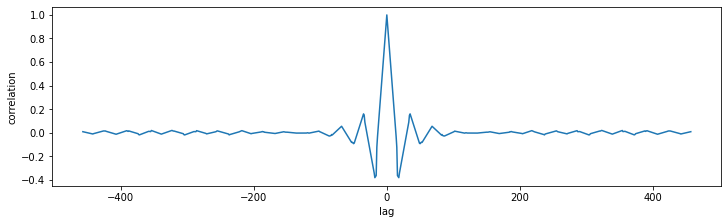

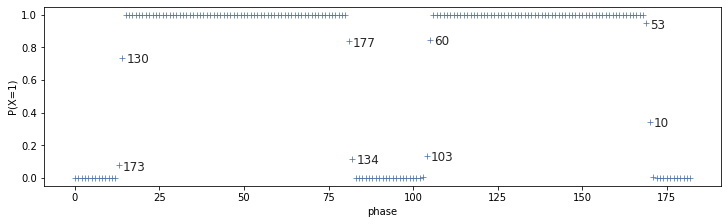

INFO:TRNG Analysis:Doing experiment CV_M1_A1_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment CV_M1_B1_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


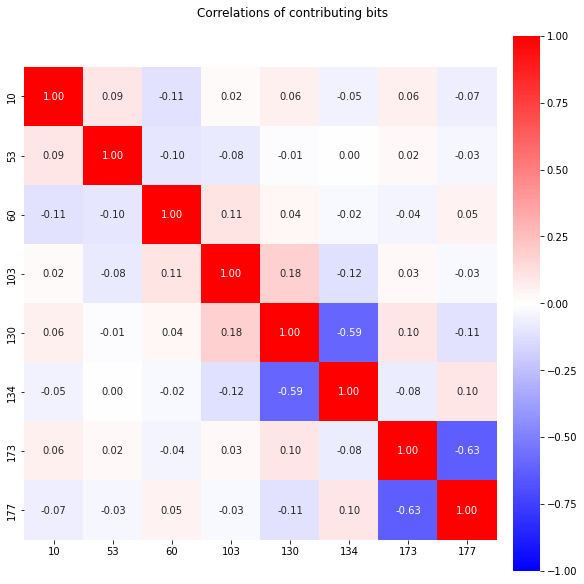

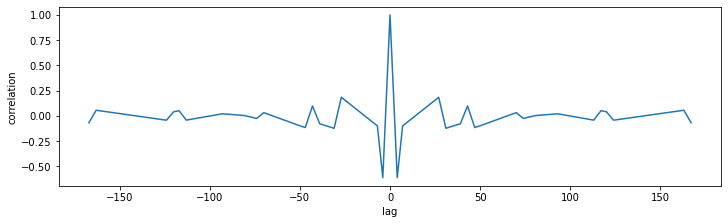

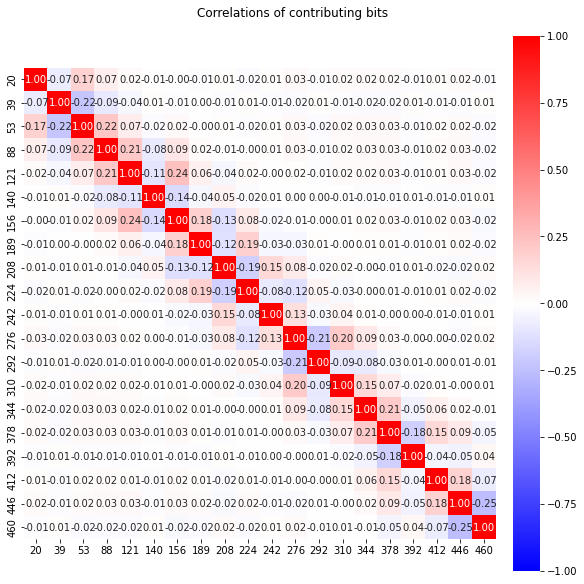

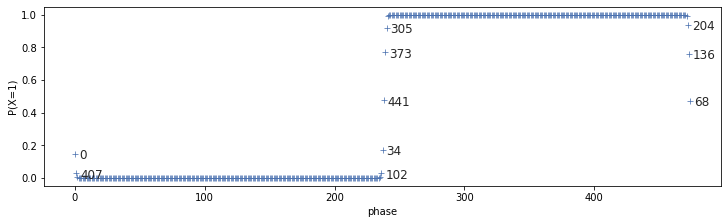

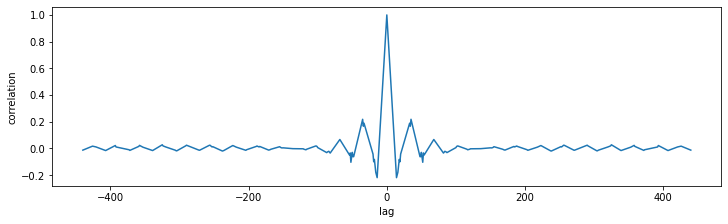

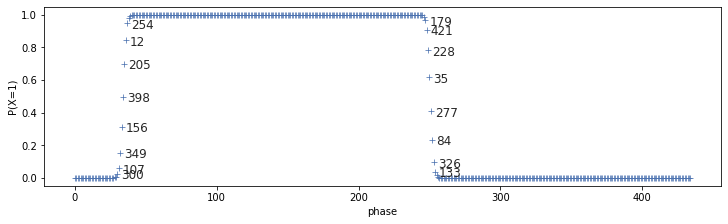

In [ ]:
experiment_name = "Intra-Correlations"
try:
  experiment_id = mlflow.create_experiment(experiment_name)
except:
  pass

def get_intra_correlations(cfg,threshold=0.02,nsamples=-1):
  """ analyse intra-correlations  """
  logger.info(f'Doing experiment {cfg.name} with params {cfg.params}' )
  with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_param('file',cfg.inputfile)
    mlflow.log_param('KM',cfg.KM)
    mlflow.log_param('KD',cfg.KD)
    mlflow.log_param('config',cfg.config)
    mlflow.log_param('pll',cfg.pll)
    mlflow.log_param('card',cfg.card)
    mlflow.log_param('constraint',cfg.constraint)
    mlflow.log_param('threshold',threshold)
    mlflow.log_param('nsamples',nsamples)
    KM = cfg.KM
    KD = cfg.KD
    bits = read_dff(cfg.inputfile,KM=KM,KD=KD)
    bits = bits[:nsamples,:]
    if cfg.params.get('bit_pdf'):
      ps = bits.mean(0)
      idx = np.arange(KD)*KM%KD
      fig,ax = plt.subplots(constrained_layout=True)
      df = pd.DataFrame(zip(idx,ps),columns=['phase','P(X=1)'])
      mask = (df['P(X=1)']>threshold) & (df['P(X=1)']<=1-threshold)
      df.loc[mask,'text'] = df.index[mask].astype('Int32')
      df['text'].fillna('',inplace=True)
      p = so.Plot(df,x='phase',y='P(X=1)',text='text').add(so.Dot(marker='+')).add(so.Text(halign='left'))
      p.on(ax).show()
      mlflow.log_figure(fig,'probability_density.svg')
    if cfg.params.get('bits_intra_correlation'):
      fig,ax = plt.subplots(figsize=(8,8),constrained_layout=True)
      good_idx =np.arange(KD)[(ps > threshold) & (ps < 1-threshold)]
      good_bits = bits[:,good_idx]
      corr_matrix = np.corrcoef(good_bits.T)
      var_emp = bits.sum(1).var()
      mlflow.log_metric('variance_empirical',var_emp)
      ps = good_bits.mean(0)
      var_iid = np.sum(ps*(1-ps))
      mlflow.log_metric('variance_model_iid',var_iid)
      sns.heatmap(corr_matrix,cmap='bwr',
                  vmin=-1,vmax=1,
                  xticklabels=good_idx,yticklabels=good_idx,
                  square=True,annot=True,fmt=".2f",
                  ax=ax)
      plt.suptitle(f'Correlations of contributing bits')
      mlflow.log_figure(fig,'bits_intra_correlation.svg')

      fig,ax = plt.subplots(constrained_layout=True)
      distances = good_idx.reshape(-1,1)-good_idx.reshape(1,-1)
      lagged_corr = pd.DataFrame(data=zip(distances.ravel(),corr_matrix.ravel()),columns=['lag','correlation'])
      lagged_corr = lagged_corr.groupby('lag').mean()
      sns.lineplot(data=lagged_corr,x='lag',y='correlation',ax=ax)
      mlflow.log_figure(fig,'bits_auto_correlation.svg')

      with tempfile.TemporaryDirectory() as tmpdir:
        fname = tmpdir+'/'+'bits_corr_matrix.csv'
        np.savetxt(fname,corr_matrix,delimiter=',')
        mlflow.log_artifact(fname)
        fname = tmpdir+'/'+'bits_indices.csv'
        np.savetxt(fname,good_idx,delimiter=',')
        mlflow.log_artifact(fname)
        fname = tmpdir+'/'+'bits_auto_correlation.csv'
        lagged_corr.to_csv(fname)
        mlflow.log_artifact(fname)

all_configs = itertools.chain(
    #generate_configs_cyclonev(),
    #generate_configs_spartan(),
    #generate_configs_smartfusion(),
    generate_configs_viktor0130()
)

with mp.Pool(4) as p:
  p.map(get_intra_correlations,all_configs)

### Aggregated Patterns

In [ ]:
#path = mlflow.artifacts.download_artifacts(run_id='10f5d0c1f95f41729cc01aeaa128c8d8')
#pd.read_csv(path+'bits_auto_correlation.csv')
pd.read_csv(io.StringIO(mlflow.artifacts.load_text(fname)))

In [ ]:
data = []
for _,r in mlflow.search_runs([experiment_id]).iterrows():
  fname=r.artifact_uri+'/bits_auto_correlation.csv'
  tmp = pd.read_csv(io.StringIO(mlflow.artifacts.load_text(fname)))
  tmp.loc[:,'Config'] = r['params.config']
  tmp.loc[:,'PLL outputs'] = r['params.pll']
  tmp.loc[:,'Card'] = r['params.card']
  data.append(tmp)

data = pd.concat(data)
data['Config'] = data['Config'].str.upper().astype('category')
data.to_csv('intra_correlations_agg.csv')

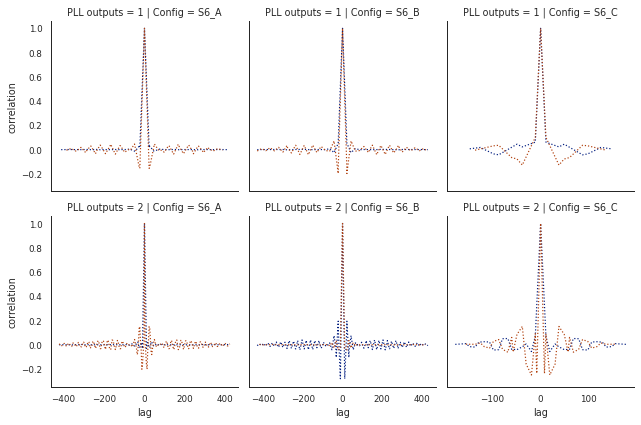

In [ ]:
#plt.style.use('ggplot')
#plt.style.use('classic')
#plt.style.use("seaborn-white")
sns.set_theme(context='paper', style='white', palette='dark')

mask = data['Config'].str.slice(0,2)=='S6'
data = data[mask]
data['Config'] = data['Config'].cat.remove_unused_categories()
g = sns.FacetGrid(data, col='Config', row='PLL outputs', legend_out=True,
    sharey=True,sharex='col')
g.map_dataframe(sns.lineplot, x='lag',y='correlation',hue='Card', linestyle='dotted')
#g.add_legend(title='Card version')
g.axes[1][2].set_xlim(*g.axes[0][2].get_xlim())
plt.tight_layout()
g.figure.savefig('intra_correlations_agg.svg')
plt.show()

## Download Artifacts

In [ ]:
for _,r in mlflow.search_runs(experiment_id).iterrows():
  constraint = r['params.constraint']
  config = r['params.config']
  pll = r['params.pll']
  card = r['params.card']
  run_id = r['run_id']
  result_dir = f'results/{constraint}/{config}{pll}_{card}'
  mlflow.artifacts.download_artifacts(run_id=run_id,artifact_path='bits_intra_correlation.svg',dst_path=result_dir)
  mlflow.artifacts.download_artifacts(run_id=run_id,artifact_path='bits_auto_correlation.svg',dst_path=result_dir)
  mlflow.artifacts.download_artifacts(run_id=run_id,artifact_path='probability_density.svg',dst_path=result_dir)

!zip -r results.zip results